In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"speciation.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Speciation Time Test

In [4]:
def test_speciation_time(
    algorithm, speciation=0.001, seeds=[42], radius=25, sample=1.0
):
    total_pvalues = []
    total_speciations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        # (tested on almost infinite with sigma 0 to avoid bias from coalescence)
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: 0.0,
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalSpeciation(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, radius=radius,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        speciations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        speciations = []
        with speciations_io:
            reader = csv.reader(speciations_io)
            next(reader)

            for row in reader:
                speciations.append(float(row[0]))
        speciations = np.array(speciations)

        # Calculate in the dispersal locations
        gof = kstest(speciations, expon(loc=0.0, scale=2.0/speciation).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_speciations.append(speciations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Speciation histograms:"))
    
    speciations = np.concatenate(total_speciations)
    
    # Draw the speciation time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(speciations), np.max(speciations), 1000)
    loc, scale = expon.fit(speciations)
    
    ax1.set_title(f"Individual speciation times PDF")
    ax1.set_xlabel("speciation time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax1.hist(speciations, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual speciation times CDF")
    ax2.set_xlabel("speciation time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax2.hist(speciations, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.76it/s]


## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.2395358453590942
* statistic: 2044.4242405304076

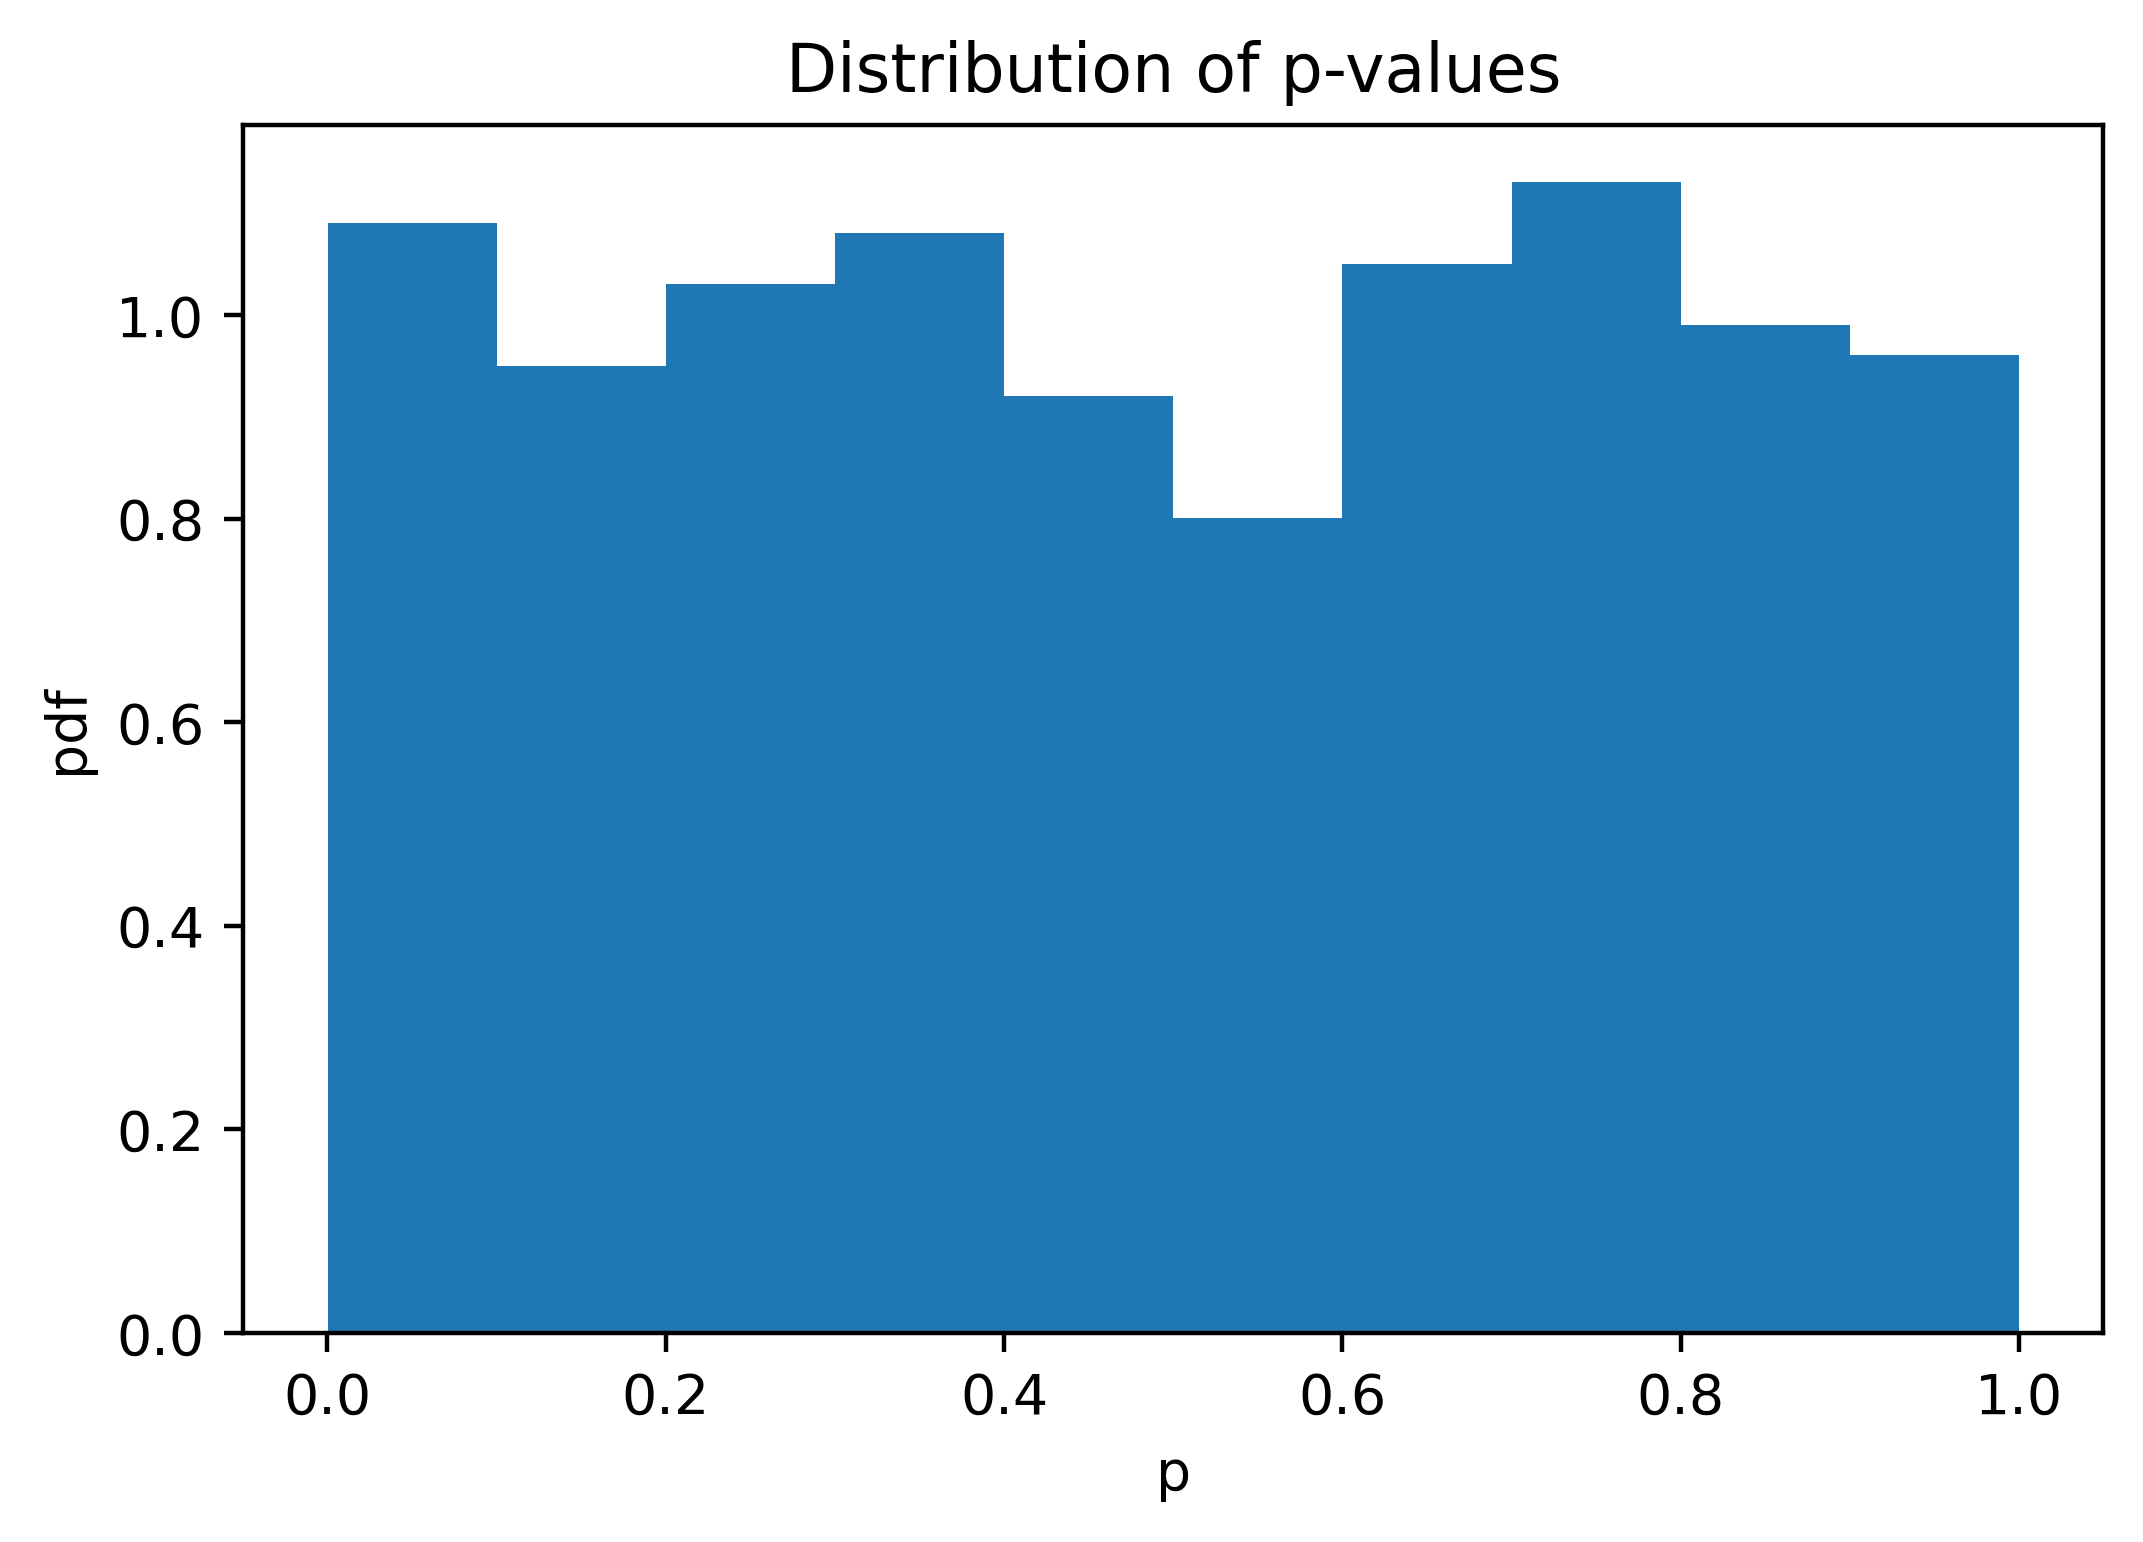

#### Speciation histograms:

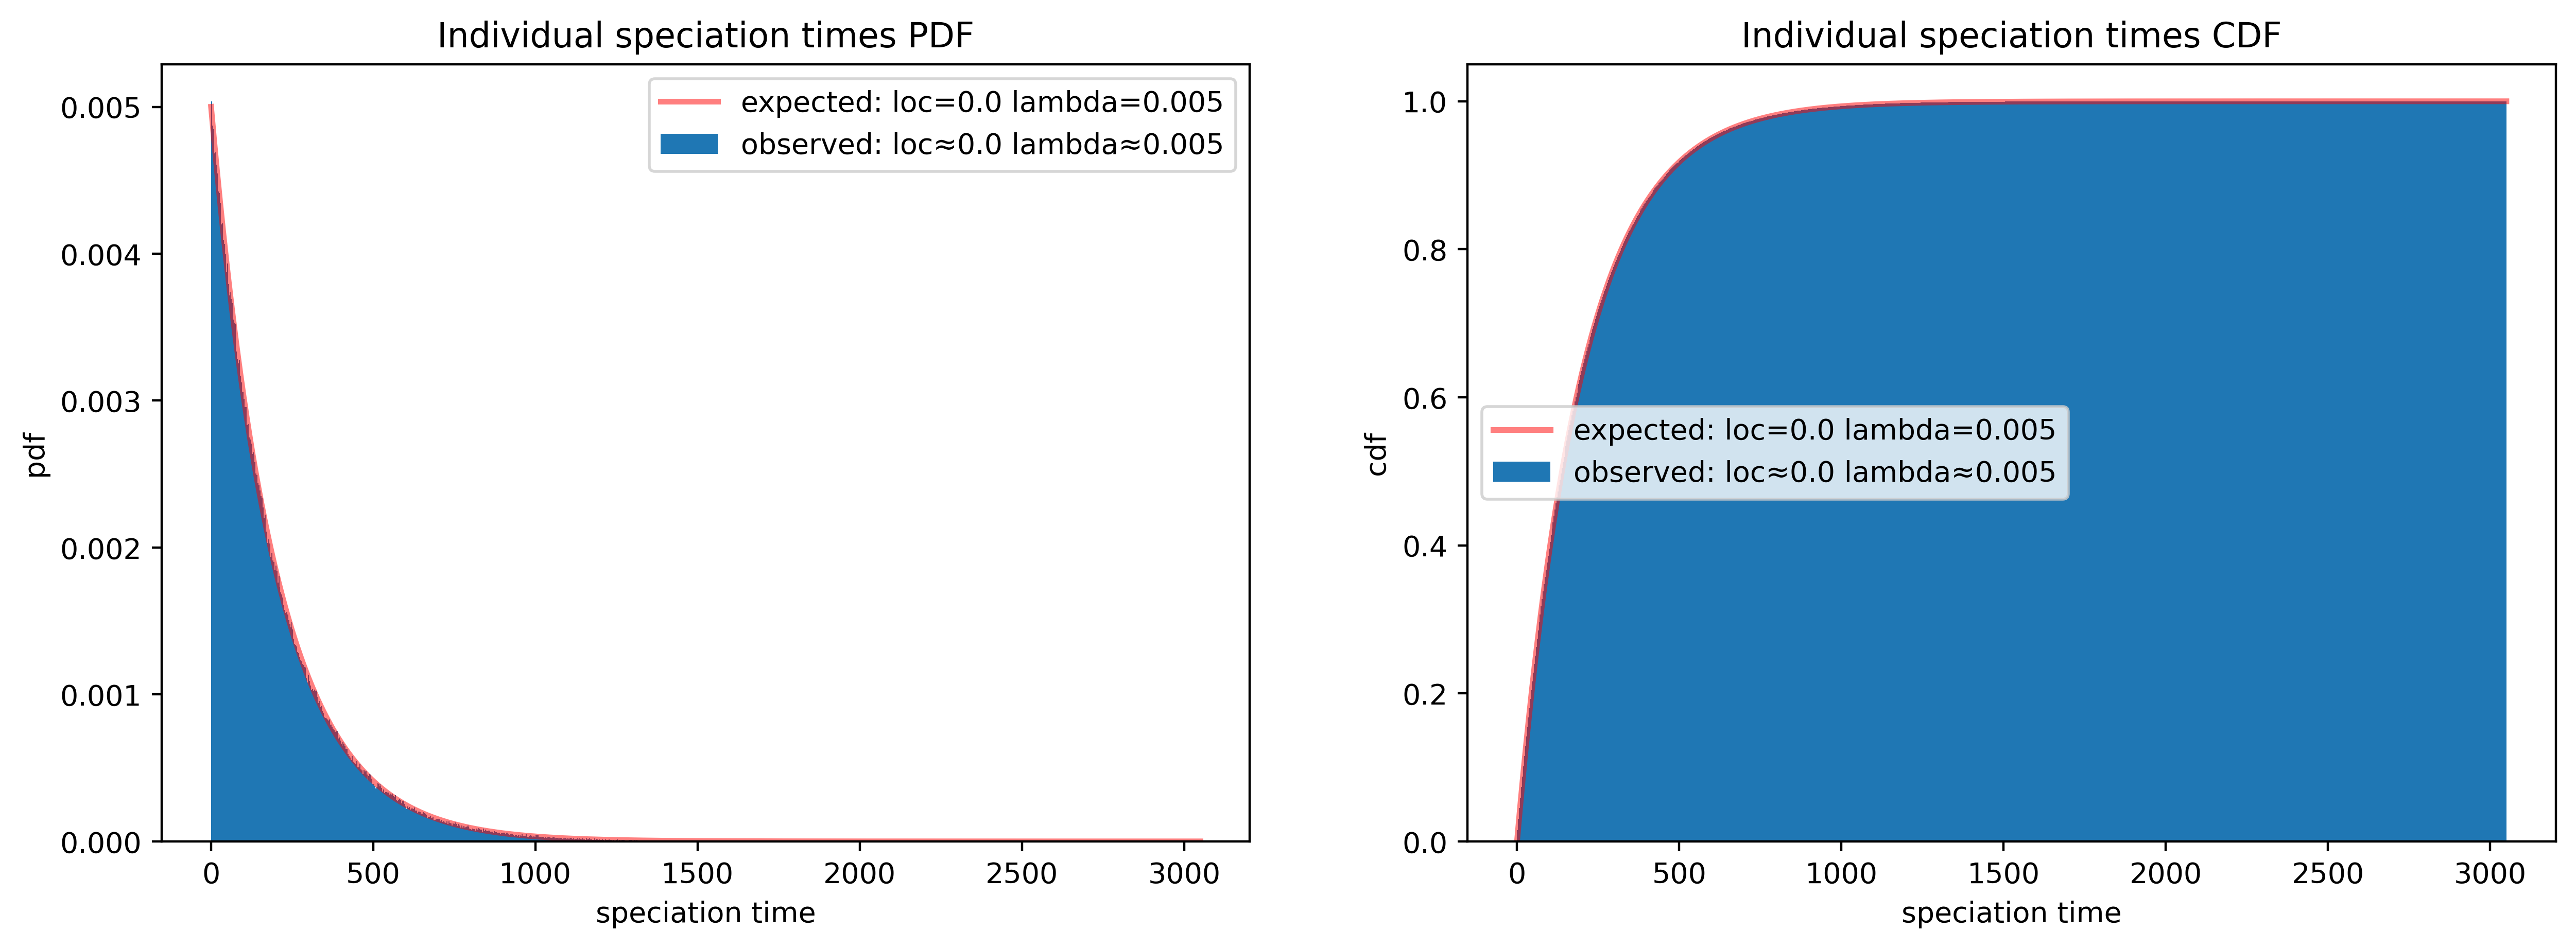

#### Parameters:
* seeds: [ 3154619598670654305 10877518115926767789 14004951894654555008
  9627077441458530762 10743603455967427137 12342089074971905255
 10959520430890239605  3096296553272531291  5827287838659300279
 13710703461646598107   873620149563859165 14292626008380569416
  7394936614842734799  5312468512136631755 12796816623708514217
  1664460731040317287  3612280194049094424 16126162559529652100
 18062462232503143247 14888884059603512152 12400436065302428274
 15536600988674485354  9543048494063644834   513746378624458672
 10556591984332715340 17239281205476737736  2719095120340353961
 18227579405576609210 17364867760608693869  4411014147052964766
  2626669154924441728 16464697567540240455 13919813387405293987
  9798374847139445539  8315317869476152422 17076100844216038975
  6781026464693817148 17721622026163648780  9642233644135654383
  8126173167348300784  4443737184355530364  9834198781361793682
  1005797061493216851  9711069482206452560 10548653281708001383
 16306997791252440293 14164902433947396821 14580362061902229452
  1238777721921685186 13992889613887140027   356286833515770416
  2748437728250082198 16716575793805725867 17822789968182008873
 13358844654415461068 11276125825378836100 11592858807899490631
 12650883062977779079  1641284441857590167  5143080383659704200
  8460793089243318566 14454440381281791158  1965517196247632367
  7038164813180448295  6940812083929051578 14580108887873052334
  3329077675863371790  6430242972865683114 18396195403431462072
  2520299981559342437  2115783364665883821 10305702664230729428
  7498146233777847380 18080364373993767214  2246544970686748753
 16849434395058170578  5295047750889522703  6188607292792144951
  5909635678230473490  5884538097367651877 13563551247141313202
  1646715391406221600 13509247134559853833   281555385429687741
 16211371355066512565 11973916861261781952 14338781428923239297
  4217553087972552003  6660849297008454691  4233527841051727521
  5666512465863775889  5343746036095555145 16116639177425687643
  3021460415990667863 13421002921263945231 10344902993742736338
 10873979202696644213  5612721250286593062  4799058167263852564
  8587390568416391482   282582185439116871 10493640917675417953
 16349554338749850311  3965617752941952127 13326510365419191384
 12408820439513818148 13522452504079085379  9208014973016153317
 10171052223125638896 13139367689518273764  1460039135660816835
  3606059114325406819 10172150268594077016 10124031601499944959
  5029188861755460763 11836080029314056841  5326221140767926952
 16969833876561424587  1424053810013848857 12543265468249045669
 15270133517179475353 18210991354895521190  1117723877716414393
 14066398122111368086  1758961901282626632  7040251449092585704
  8402235098419006192  4239567707214249453 17542010165470074787
 13664421157845196408 12388962338955979918 18264105112902892982
 16246290677357476105   438110572538189479  4398396071757712586
  2638728931441381506 16533053597358316625  5443170808172321399
  6348289835304137903   862465515152347330 16447654494337032275
 17216236546555011200 11216225172330233954  4164071617589390577
 11452303834764680092 12983291948119360915 16295158695539550981
  1266404350097714049  9285000360513490648  6767665386420374322
  2724233244371617105 14894582036947270212  4251232435322907975
  3978466859971017320  1163293991144777634 15593322111911363461
  6166370623004737828  3176038802509655174 17371272106990475532
 15865331918711610412  2635557413233019312  3099318832510274082
  8039971890169241556  9483970167724755068 15413889243297111479
 10378441031529504967   126327958018766865  5364472179053115938
 16498604262109856494  3523754087534880461 15671631048581739303
  6041567224258889316 10511159724817475874 12036472896881907846
 12310025654322221870 15032101683463063918  1098722629098297960
 16595468553410251087 16273750435983581439  3717063805429246243
 11694594714548380839 13810044626883245702   124428112389322739
  2071804367833107895 11283673933796195108 16003718854492668103
 10490849192684194462 13018421993207649357 16331796597528357962
  6068485501071320209 17213440282552088162  6778090889366157119
  7262248169961746794  3276871712570709100 11586226506060755287
  4340503374308162712  4478478864128861612  1520548531013317847
 18133241770982676419   685832265586120138 12628832184963876559
 12733532975908517290  6712688284248939349 18289356561669090309
 18440854125524822967 15792753257952483942 11520864361237404554
  8810428579454603069 13792035584754929455 15356607110164054788
 18231751553393443747 10845696796808454784 15800302231757270132
 12161826435325089673  6152706531606698289  9622411862852981564
 10390686406068904356 13496430936937486135  3889225806031024204
  1725027323037030508  1198154789200251913  5038756069341523296
 11487386093410044653 12935028862868714707 12693855239292791839
  3420685444963672578 13652017325959550301  6934299364934900768
 12947829121997832567  9218308673285903059 17593725285011200438
 15337250531072663757  9826730150201905552 11761890384668254943
 16237195157359364754  6441730051556432112  3924039562897748033
  6400331191284715638  5444206651791427348  7278657342561194390
 13048622033736911589  5216384500291803265 16573318740927650517
  6637936067508144759 10108774688854113332  8857966473854164328
  2866939025539725378  3607648207323447416   515316464250828851
 12037708403349157304 11751333646872366703  3513872607593976529
  4402209956922242956  4563048388064246427  8056908001779865006
  9165958307397376019 13544482723674011976  7932109891184883964
  4929158039335376908 15315705670653066188  1417537008282048852
 12185484766049903379   206018541921025079  4522834678957218930
  1148677721417664960  1346877476340202089 10848368294838505935
  7406973170080918168  7605866555665116703 16330525356075193248
    30101204955592668  9955203652413074741  9056775085979924212
 15839187773004842308  8149987752580539166 16375994838759166692
  7394826597369627158  9175405078399479122  1229706901255723799
  5763479405632106955  1121516777928679902 15661274082504074556
 14717941400249921210  2257229703738929678   351656096039696728
  1843832729335033503 13923724965159206224   618150909361718089
  1854995527622532889  6781790631797689188 16959572409452258631
 12100072602585116713  4989099507638437206  7089646694987592506
  2439970669674761039  1852356470659673201  1926761245159401171
 15668019278326824266 10724120214689051943  5522541416223564841
  1806813395344521456  6895210284952150870 10662458596791327835
 12606640012522322324  9804699552842451173   239997845301998574
 11340492102128994567  4161320522355830062  5250650041651187381
 12249742947628515437 15288180078744618271 18138117631261723585
  2259800752524372397  1051189702210764316 11090844314283964708
  3583842924441023550 17272089551839290617 18072606205168933795
  1855270005183705922  7815315544116924652  9989525887735253727
 18111092402272517900  5242737125091814894  8450256433957964336
 15569262233166213394 16567725716598198025  9685535433896918348
 14313288146949502559  3592959380476160088  6592344896081233929
 17495958556792470815 15681094201562319654 17145450318894110309
  3281598224791045824 16808932560841264191 16274157351189947362
  4835978711656044834 12067980131715325307  9496496928791093424
 10103666412688047719   216324408020968778 18044582808174338968
  3680871694208152975 16902336770253981387  4658574654861014137
 14088267025832684249 10979611511005672489  3969164434123672761
  5483678316126497179 16365759337615606188  5530797204283716176
 11538293426857759414  1452720158522389996  9262971535432333714
  3835788461173932595  3170436799826925330  3203088450672697418
  1565572973482193409  6302427679691293707  2903861636437535755
 16362770420035138378 16462193117605635144 17016717007192439425
 14837427462014915916 16155490314164928790  5066496549520596997
 11993856826001183923 13757685415983358025  5019485677636698904
 10319712920586418185  5052520144475841757  3816943857420587358
 12709468880786457378  8689582769779688148 14730091952604938397
   626770767324779687 10389308549539979554  8500494626819263060
  8870465161818008882  3423984694982124205  3130790728630964043
 18266787706889686621  5700763319940997790 17896182602709159570
 16322721232004143615 12819637180132739310  5540298419810394664
  7498249780300610563 13530607579784548338  2774830665356098762
  7296050095525767907  9577456240413471225  2773470807035778362
 13681716619752786425 12328065903820429954 12546517989978314742
 17362684138701763573 18305514186720965427 16463822902909514250
 13753311460595806592  1037291506147584577   734799789501310009
 12893295795711683622 11129538099836515553  8799863170031167428
  2586346651909218900 11240965928839875835  6309768696887312197
  1220039459488691537  4030665927070149310 11569706865561579938
  9361551493581764569  6672064668517297479  7806771725378722514
 11288604172803133165 12376423110436257317   486972392171959803
  3742051527503132293 10411466414142750586  2913849191124346763
 13028868707504352650  8192535103467262451  7787032297670841455
 16734968370082649487 17420132631113413737  6285069123661026242
  4502224717372071847 17548568167429597769  9577820586881453798
 14774257505080040028  1781925452111786254 10440523586162825073
 11589686127739341391   386618535286889889 14556146107101986424
 10114396753291621511 17868179575426312106 16991186546356133583
  1879351542625696215  9288982678340806562  3034517194231210566
  5398821583314513856  9813296162892064171  1809310636639756834
 13904045536626182518  5375382289441303391 16062044162196428712
  8187029052047258939  6739764698171032608  9962087459768148163
  2451133038715165697  2245731552281746873  9820361375590151797
 15356258427092066183  4557451891398520752 10954694661390317962
 12087183618640364924 16894701243486061433  7102094667769527110
  1940856550134330253  4007746826142896623  7868963303259557998
 12255551854598161828 17008703565504725347   330462604980064968
 11629997038937766588 14550974023929281284 12604437098527317406
  1170957064774235896   573751567895924550 17748190002120648691
  8729072317957939903  1074711977664914012  2619249786387440636
  3925058183714327937  5232557787290835983  8940265019317854418
 14276760718987594945 16658443165070477328  3691262971733787397
 11513589625876715471 15819645990203020558 12009253005612829800
  2129036220471289331  3210918049381880539  8269447595919956920
  3969848858012144915 15998513089532987292 17465465428228146193
 13317870525998320251 17788827337054128713 12450296378134718435
 13091202672830030715 10739750727449453275 14596265619379129867
 14470895778753295379  9522681400025590192  2042693622600172419
 11327893528723270891  3574235239516349084 10240682445703606828
  2864288981103266803  2285743975283202701 14675884094198451162
 15694664946450363054  8236361271063178920 15123394198206792130
  1288853536736413843 11817766958814687154 13172228275416719358
 16983265125773799223  2411087347692373022  9092428485675111030
  6904558028438609067  8295664514907422576  5869087144583147923
  9218057284264800536 13244630130087588425 15726130742679821597
 11826557267391183144  7604251998008486701  3355292529610571067
 11754903674815460501 18427175418070993844 14797084541385148513
  4409787325639132335 15436644859159148519 13818899318581643947
 13208395876834246924  2770383428161630317  8299393669665520253
 15649887298102097191 17860305523432840509  2875136957451195299
  2088065846882618383 18281166579460406603  9136263298823352742
  7138532952133368936   745831816773485089 17533509534417311789
 16257135266139029700 12560218609220383145 16527050792463000278
    50767972124464888  6295988308128859913 10111553102189805605
 14859935562416706079  5507723310931284313 17879192848252963036
  9662883172588330219 13840998290880324351  4290326255438363869
  3289271196693233869 11120649513169311366  5028184781115960979
  6885517196839501056 10727995709914566645 17727040414891799288
 18385761022736904113 15258003443915637401 10470834115344001154
 14800787814001689849 14840796125604908194  5943405364070412509
 10852931270252536176  9996639135642076541  8128305263311338345
  4909418590905506277 13548937204343522560  1825971392205332162
 13271353069668406980 12763030348450068141  1055829103316234406
 16423211198864056374  3165522807307011551  3574701162633511515
 13899488064257655834  9880689547517728922  9383243999737596255
 14833645860682298260 12928358134228139428 14998255163950592815
 17177875080480003076 10524485986831328944  8610943534057288136
  7970774594183058344  5802150751100929047 12513027493231426668
 15574005216448176545 15051725769105402998  1081952307171559808
 11598068592119218693  7842618266008008462  6420905800021041139
  6049030817040475656 17205725145501130374 18000453239768637728
  7516276632425924135 10986191458418560462 16474553221360488802
  6524273557537064682 10040450549125534646  6272947301487765219
  4768382252987591553 12394036942245082248 18305572615234075091
  6145327373230352220  8637614399487177433 13113240899540600151
  2016926564973223694  2550603033109895290 15244791480426886582
 10807476439566822900  4027765090378913000 12766850502805846944
 11638087607467587839 17623460037042456380 16988664659689491326
  1896363944797359814  2368843758835320908  6284882522650384510
 10123800315868463187 14942137678960817074  5555194289451492484
  8648071562382196003  4752962262719571875  4648541746531141708
  2891615250154436495 15683037011020804962   782876236562784131
   676857978474269958 17610183270447073227   159543156392691916
  6245775083402228365 13986860277789244753 11044817116527577263
  2305404754986146567  9884152135211496062  6835428008307069386
 13867722233072198283  9281692110091334819 17111453670814136327
   596849092767234207  5251910414969183976 12944354665081569160
 13558679158840393063 12847485181419896326  4466968801190191337
  2040377420275719169 10368747021517265691  5806538832250511197
  7174247401290112762 12221751643520160872  7212506218922521867
   311291093948169840  7431146475150787457  6575728802019706713
  9899183436095715163  3493969916290561373  5827297063851160419
 13007978882432844651 16534558788029730369  3683334059634819505
  9896120222276621742 13505040080172581959 12035430304999313671
 17600700158363361820  3077792216626059316  1324948494154470820
  3242883786445704800 18293459518461681614  2688684270218394036
  5302232971956909160  1635606938219915835  6368083254115713347
 13233712190498006781 10328198827406532039    77938100071046343
   412509345832278191    75437591042983544 17684051951072692879
 15896200980466894402 12601511417271992695 10575990016912457613
  2050240631556073326 15839281832886946942  4982860771888951365
 14437676619783881095 17192960773709931569 16745574222323823281
  8202820859510832222 14670114724442607100  6988892323259324498
   188797362286041825  8643968467994805009 11903091190769587355
 17348251020439322858 18326340231217881563 14471905316986186783
  2330073170732440501 15774713341536227481 10760276711432439900
 10211196147395488886  7420652101141811583 12893286314399022665
  8784916002355037842  9865674801208999039 15995718765386618623
 14405989437687750755  2758007742790445254  6896876103500555708
  7963980496591412467  6232239856224504675 15658839124693411850
  7196027026994802423  8841699251748055227 16907878743691821274
 18281070255826688578  9518719307530563246  3078483044574880298
 12391455260045204836 14704654296902259588  2834981580026234623
  5655845492405281563  3575968013050964539  9200619171486598972
  6108662259071917025  8303240143558454452  1280871328362790999
 15711850503366242859  1738066163871899487 16244697914033690655
  5103603845438154265  5769094134603934887  6284976978861022734
 10374332502973379049  5803780160993131771  7289029772484180874
 17721048297851831718   167055256704364678  9885098226986766577
   990331926414659053  6895038440863994254  6755695327513622569
  1260115287555048419 16710200046507360624 16350076342515742682
   829717338433437217  9526791808470121313  3923646669890913352
 10142692951390170357  6303935381357742315  3888366774211469030
 17674369959042098495 17094831614560626929  3593603761257492245
   975782040356154986  6129892026906447696  4972268526883807326
 11309468231109382726 16285142114719345221  4491114307833754855
  7728164471774145126  9050738191974184859 16276241515165113632
 18112874004252767816  9203474919550317277  1447198267568105332
 17448414800745860733 17395066661204649824 14763274928430280728
  3491969136336997690  7016929367931160707  9909331777517725843
 16569070408571418046 15338253357201015774  4876349438287868085
 14465763221949731372  3996155053995326804 17650213349473079937
  7534365442080450726  9472016620342654943  8721076628924157134
 11814745770302778136 11180240506695883170  7079953890116974666
 17371717720238164525  7333621855677181457 14783372824513782389
  6308584575524450218 17793748585744968979  6788266160036251550
  3725925853601093354  6297701184247771612 16701265717294366205
 13583256469126737817 12107101565744512208 15813671545074517757
  6105112287190050642 15523948346549772465 14702241681613015144
   120841834055947502  5838599307296196301  2202248295103011549
  3473536078836351370 11742992813578811428  9014219390556924327
 11173487027501576767  3067045054777060125 15411231734203351933
  7912660015269798236  3233923871639748563  5993547833686478537
 11743367918659043428  1377809735448941192   490795940312190385
  2375912405320715695  2962568942153654400  6593068057007519368
 11379832324154333845  6466801185295206814  2193321453957170840
 11170040517469920871 10375623629841771220  3076962826168433421
 13847520188203031509  5541414547456891975 13063764744489430386
 13846270066305507621  8806506402734391884  1365028536254613786
  4340704420310567086 11546556841068244853  3092655932754271531
 10146455602851547492 16383086146850732048  8827779254941554551
 13989519272336241870  7965096324710305322  3289875783114105095
 16780690716609474920  5552040358696961611  2522034286569788658
  2656422589650392518  1257621933033429673 16222539843393410479
  6110541558312103286 17601050769221498961  8139452139698005290
 13775134244636837332  1274767754805777473  9515693453804530136
 17846217409119877150  7740840160756746673  4073968016506011651
 17632002732217384842   732602772105347111  8602853404185410287
  3551067302839922008 15670842663707574773   135133951687712309
  8643144066756150149  9289426911596661611 12861538307205935325
 12949978108442353170 15892772585551796786  9919097622314408607
  4229426468341135987  1572532376321627861   174931442456089769
  3675274520953305817 15878692395207095643 13292982721717962467
 14421410253150487483 17651257418626147181  9688289707005279553
 12856283634459801173  8461774051546875209  7996994535147273142
  5459760402693786653  7833316552658826234  9901922951223522830
  2489000961853944003  4037617243397005927  2916208722596003466
 18033893359402888691 18408696181301090221  9142027747038632950
  9385303554050557192   812154050469003275   712800175337507799
  2247706954046252275   937217426354067058 16539334140354493230
  2867632001590273072  1739711739254820792 15897959545830093199
 11661029395286966696  3856345575041663770  7584382939726469780
 10011943487534238343  5589250739115138864  3429297975365638941
 11528299753311588096  2672948414105686390  6719576295010246011
  3455269631471295224  7815483621046488276  6670457669194381934
   158299927265963433 10003460781198230372 16502532903954080253
   746242673800673714  7355464757282949968  6701880106085113418
  7341606497151719375  6155109728874781989  1633257209364917392
  3885802499196937600  3728027993524718857  4940524533518245868
 18081462679843978662 17859249040070544499  2317162214373254204
 14343124030845897104  3229228422848836213 11684969795241439945
 13879041626522215708   757487067904125739 10867004193770411566
  4040245588370789427 13438524014248484631 11991139306637514377
 17616537781799761907  7702910182595227708  7279786380736551649
  6064104233343202321  3088137575178171093  5699776372428521366
 10247955744219591846 14171819381514321268  8301329001177582412
   778738488739007327 16757526776217822843  2854830642768634397
  4817964666319313982  2192616934329683113 16306979561694470907
 17642911811010897086 13257740905154123377  3386090262265023353
 10489504945137291291  8597470368086908316    86300700008485121
 17525371690974470603 17669455899797839529 13973487674307958465
  4525989056032064764  6607238318175508289   529675669358177142
 12861045088130065570  7322471541702299548 17420436362116852092
  5673158815910408465  9256835225759000498  2861681861209973156
 18057144145129452378 17000201683558504944  6081091778328054939
 14830981555632777405 14986751960577715325  7213192541687496947
  5406933992456417911  3337333170684765019  7724206902143654247
  2384824054340278107  3572123356111032383  8995790899432819650
 10738232166068212882 17748279606308786649   944158214102730274
 12438772523550105183 15414018330155142556  3578311699481847845
 14079788255498220507 14103663180303999106  8842099106658117261
 11615728476311047344  7898621329565226553 17653959342415375626
  7659329026769202760  9076751195005195972  3256119982471574931
  7953095185477109503 15632950187230764692 16491097194509174248
 17909989277592669452 14131595401775356976  7399838560277938289
 14867965625113673882]

#### Configuration:
```rust
(speciation:0.01,seed:14867965625113673882,sample:0.001,algorithm:Classical(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:47<00:00,  3.48it/s]


## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.46340358042598784
* statistic: 2005.1477747345539

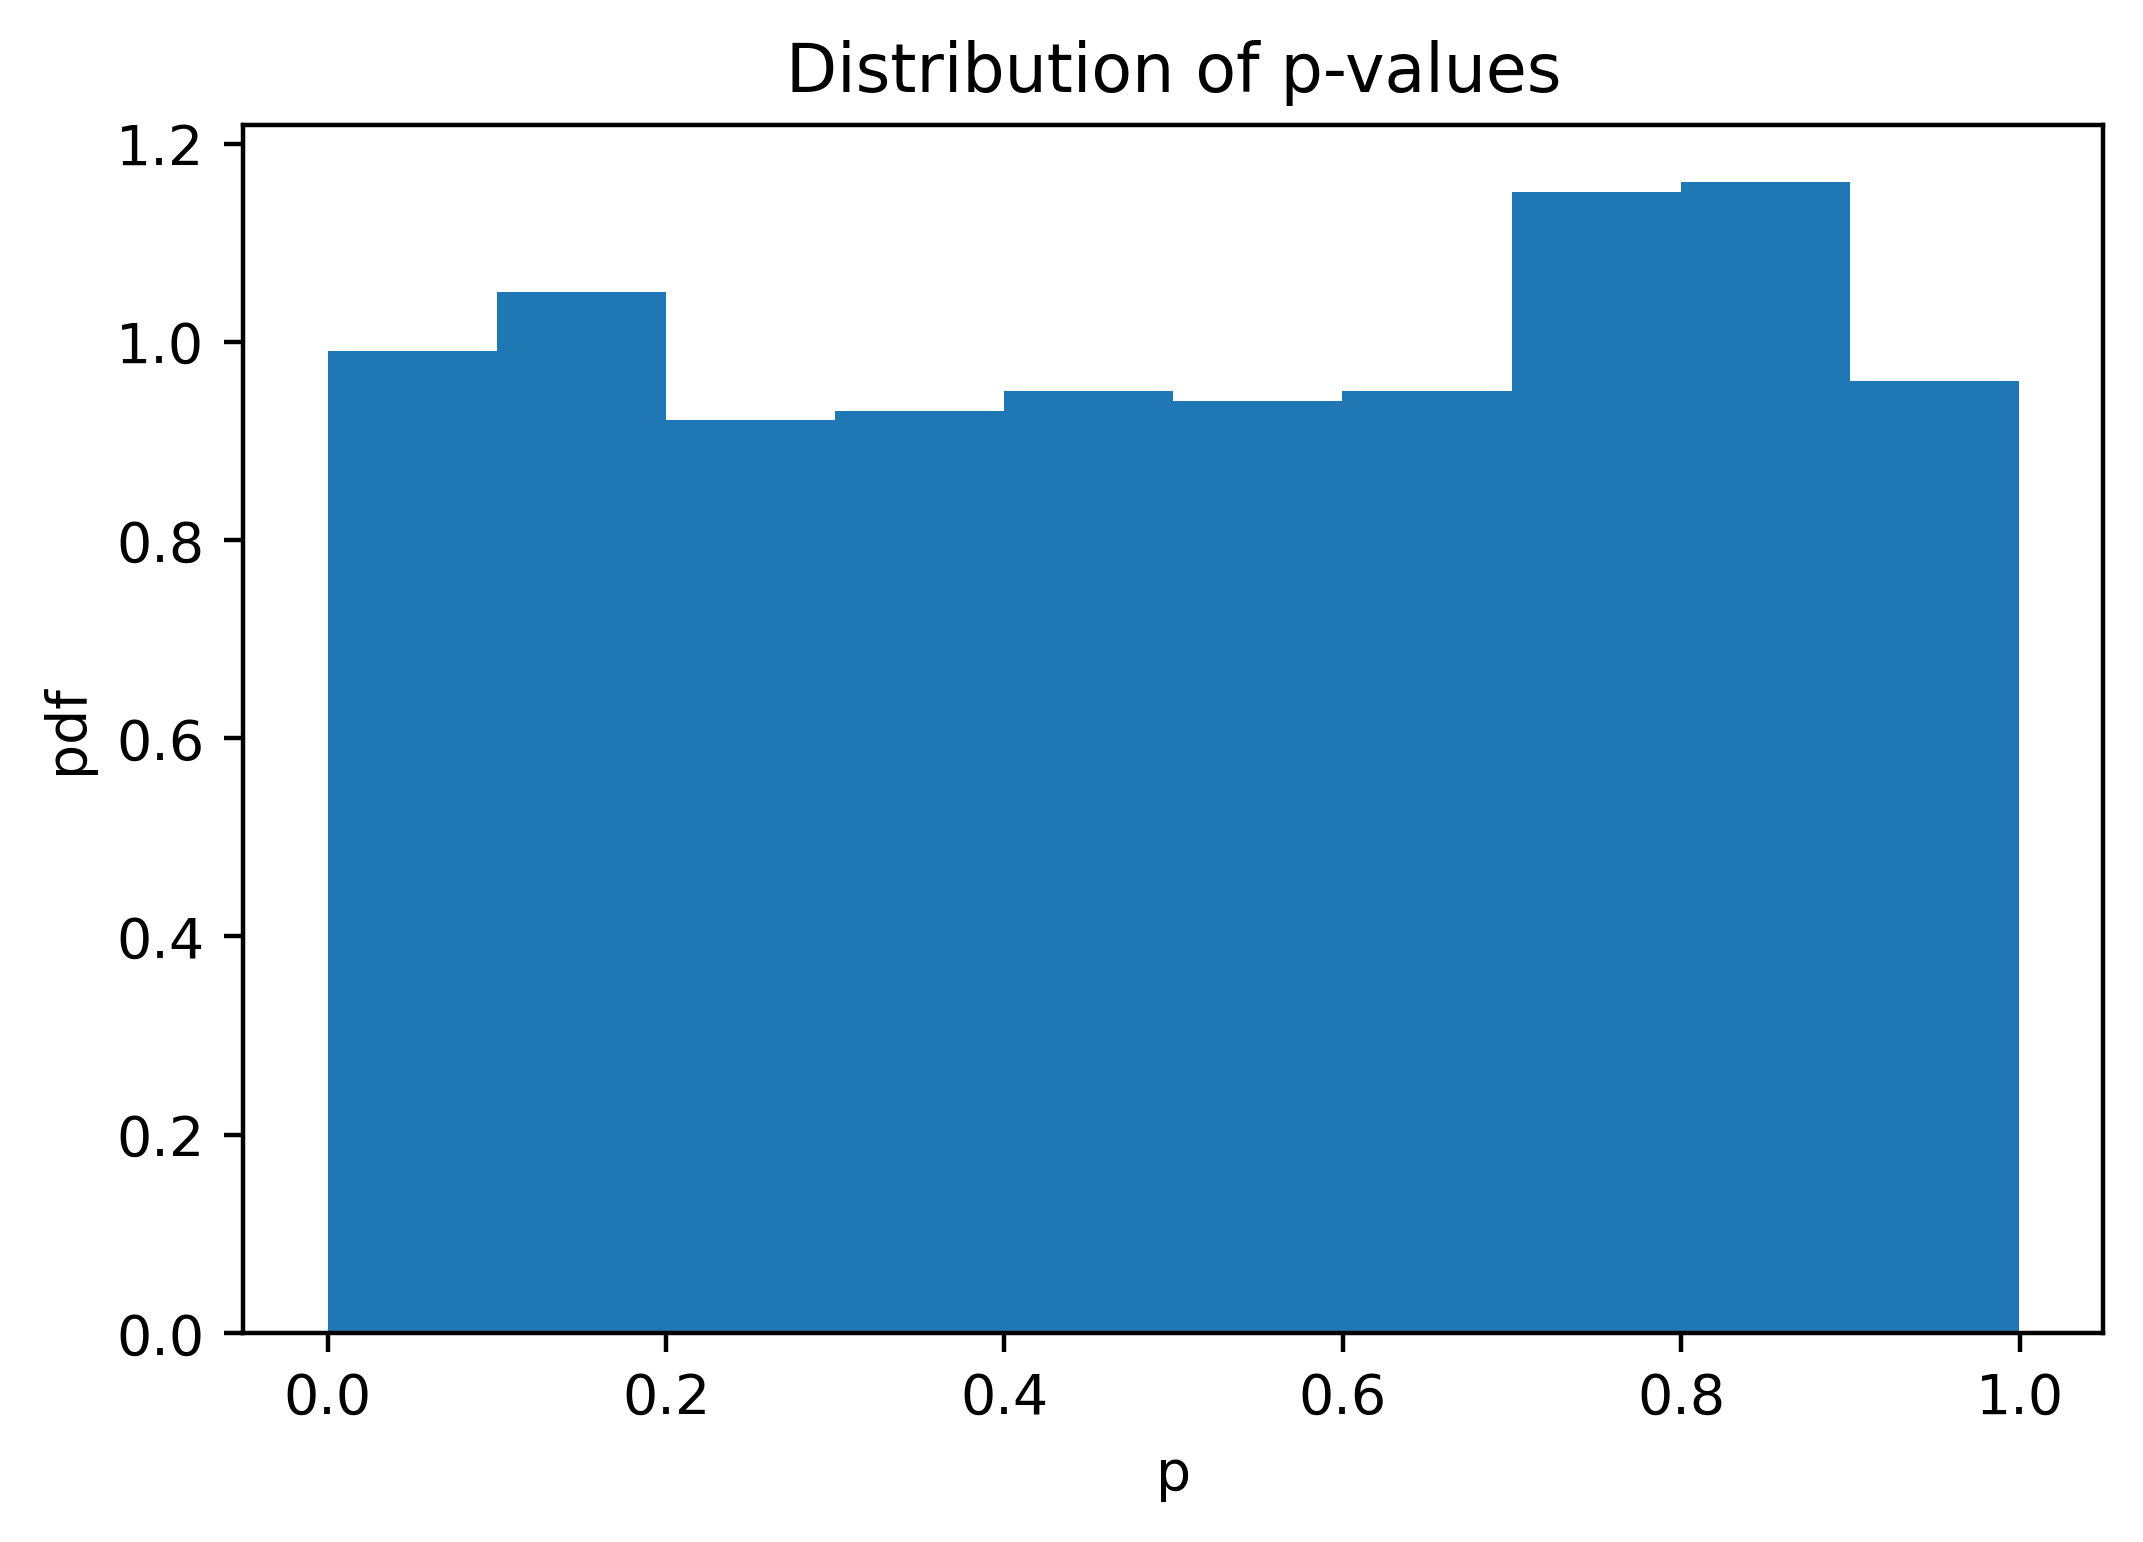

#### Speciation histograms:

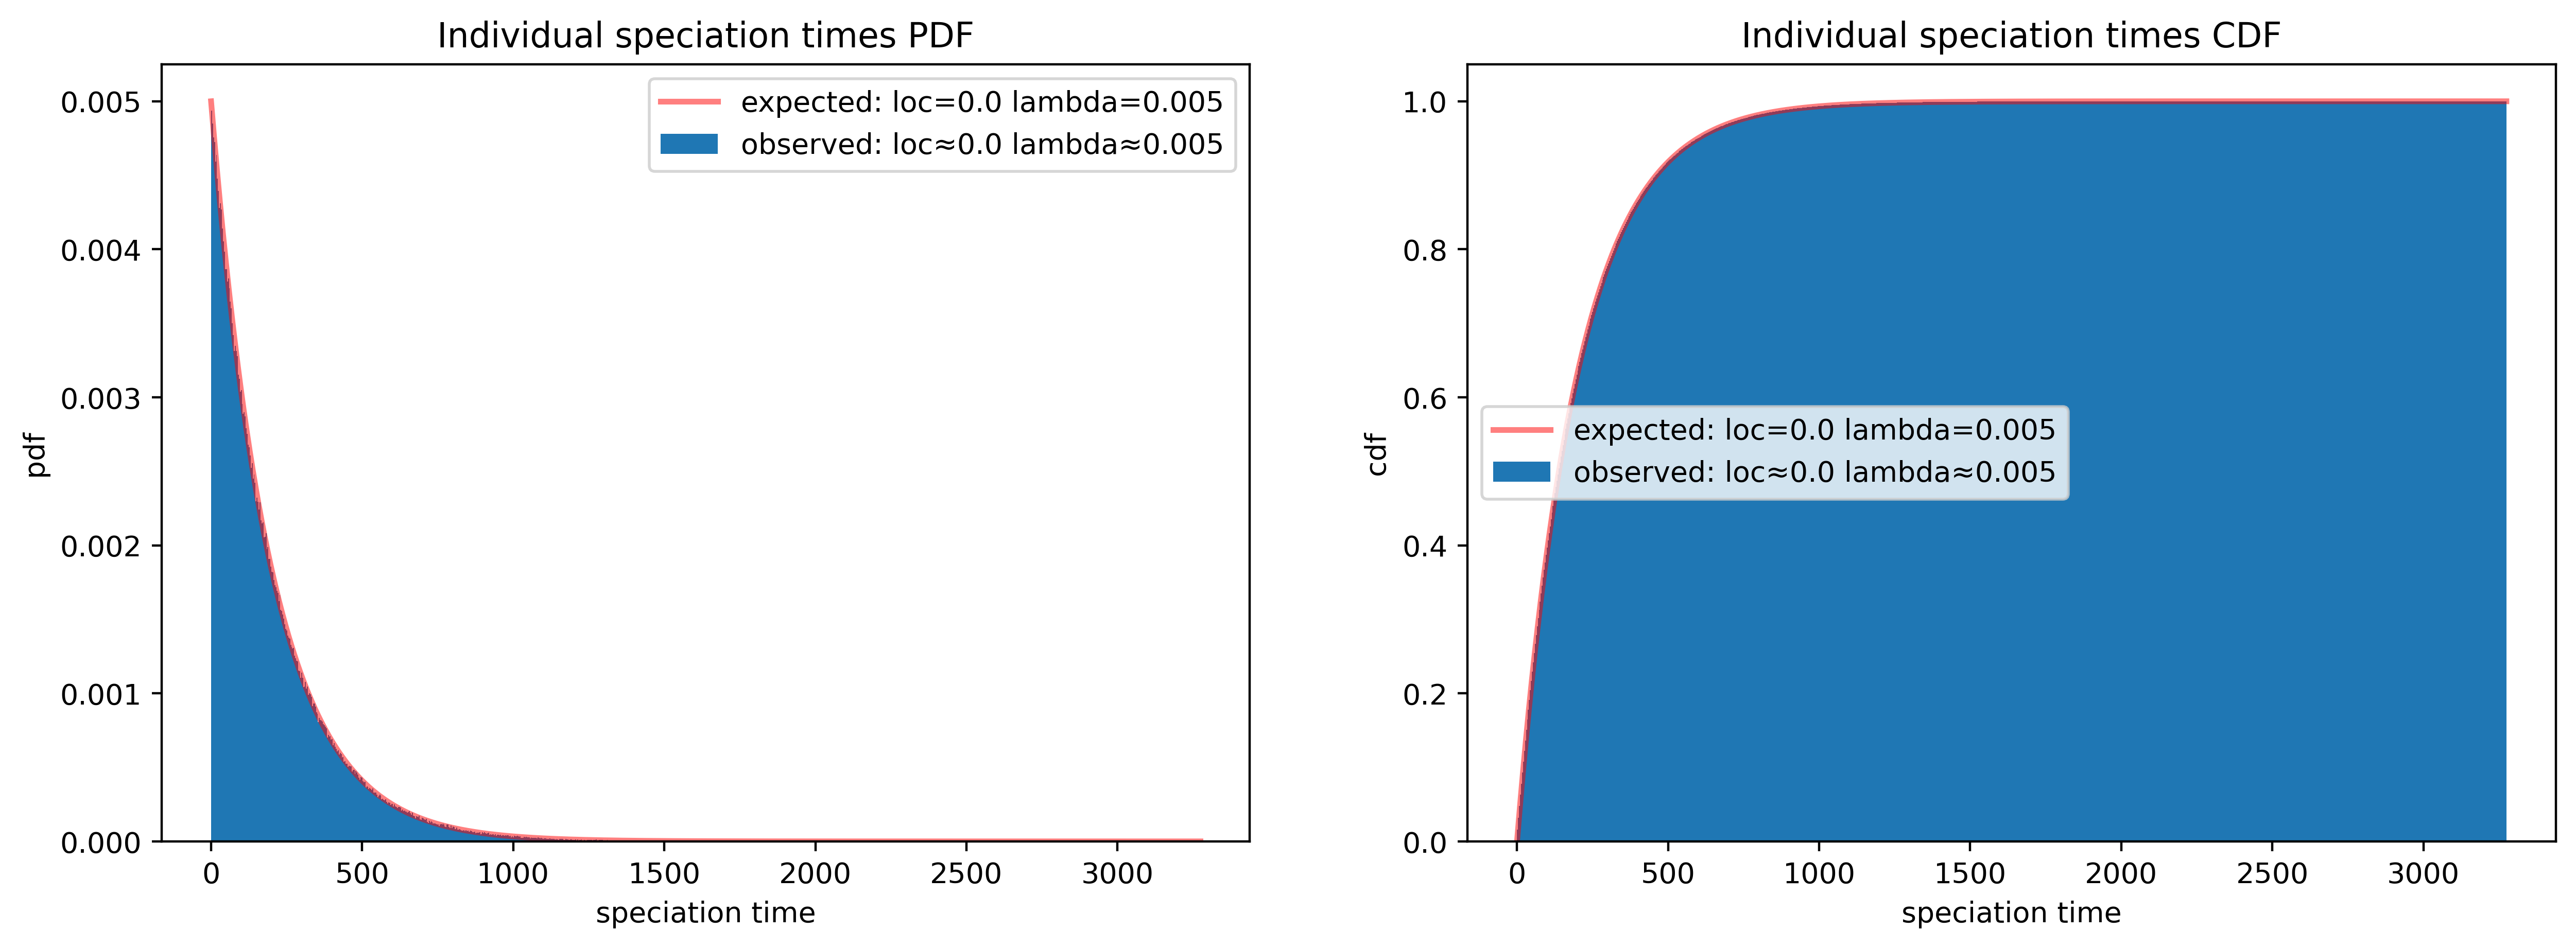

#### Parameters:
* seeds: [13338032474982806733     3688955158042651  5752446011853399083
  7094901943960624209 17264157213964966190   357866859150660822
  7997412024728026363  2513110104126483326  6744585769605054441
  4055038380938485451 13302122884814788961 14087600774717972628
  9246720847203550278  5565085728164389085 16566575705966345872
  2829310598643918591  9572793034423356239  6957496499822927996
 12187424070734270430  1289097145658920914  3353202622599790700
  6449195694329765433 17879035406900732752  3328017317100327601
 10803738792062538495  7535927694376723850  6076439021092866441
 10484600890936492727   305376813532953893 16600635963982631084
 16560198785207759739 15934683366618273311 12774465772868726217
  2671694294804799080  6665326720351491235  4266940348421346179
 14821413594710152752 15237680400500735168  8298457107515822169
 11937271195949812862  9235766570934747239 10308009795298404513
  6468980904191669247 13470937164343326501 13984134291775414611
    40553046470132773  1935584076541101983 16826642058955928852
  6862048588182194623  8833759731774576828 10861714065493959224
 12880634204956250875  2193899144840753357 16936634286283539695
 13907204928723057673 17898335551091846560 12111915491567498024
  1946112600247720998  1265088532929476536  2849734835489941036
  1244019137896460476  3485555252664271549   868923830706031008
  2604807263561814694 16692319234716913059 12307974811893712958
  7084166757100988315 14146416424501745608 11287412530533841968
 18082032961663708949 12212603829399044731  2500251262031726345
 11819021011076035187  2801170665729063607 17940501170279389263
 11340622106167526635  4692445490991918338 13830846069329471869
  7289937547822579433 18081485160767720878 15958594219469431485
  8652477868043548108  8121278037239432476  4511097808518905763
  7312296946095497674  9169439439100196282 12657875545949330839
  2703368116137379026  8835935035967443736  5589839564343804970
  6918053166102580283  8017009512328984368  9347920080721743684
  1325920533457724149 16256907284895000530 18017270240776421819
  3227723619301662923  8795125583727396732  3786020026369496738
   715033394926443051    97264179289415129 11979824855540094086
 16429618817434354254 16701528795115328341  7681278265481832151
 13228399367581057119 17497603949759317180  3354840586779106548
 11327984731746302682 17451979354651629848 13422556972422646082
 14194900396215392184  8234294482109250139   850909180426652725
  1269106164001596279  4686610173949115505 18034097661229534205
 13521536438832248871  7916296567891544513 15667209348446414041
 10891683161617491075 12438431560418411355   552081978855742557
 13449498564523496927  3086322687762276373 17474035478128596001
 13058924363210000248  8655856971546387849 16698752124316271151
  5473870456939030198 15686882006848213328  2470627424956286315
  3232641112686044688  4877656432716990213 12823216009973488958
  7504068220967606996  9972767697041853676 17061362523197603860
  1791413266793927336  6184253222307790599  9022615758561955924
  9821571954883225132  9847691151360008080 18179371894605564596
  6855946877559494306  5208342838064007852 17939292447253081721
  6624136442319621921  5536919796590508689 11144905351273989537
  4773211499109328508  6178739271574280576 11052815080244496197
  7222990404201074581  2255212632867203696 16906364298052606091
 15256272267053932534 14054095756645236941 14505616200576133953
 14339148998055897714  1971853723744642098  6792370339931055801
 10279020264457238891 10080491094362731286  6950296248779150926
 10128369428791342080  8251062566861971951 16787033119869509054
  5611885072356160547  6168993553083070436  2913764279639666512
  2415784261309109907  8546090229005216163  2209854985145536308
  2074102659369445555 18176410263430641852 15310678671936603199
 10837713109414516129  9237218772467037931  1136686136408052357
 15387854609709981707  1578444440147902355 12780188370671294018
 14268294839381502001 13843395727115536772 12203656075833404522
  7829227471373247230 12895870073333975678   266614024179849600
  7506739191999242852  4195156981890204037  7798505621739536798
  1884888919425018057 11904296052794281996  4748052076918292996
  3026121393626967637 17536193508519133033 12378391876891314843
  5918818427470746921 13494079401825335706 15698138430686781538
  1755924697160619280 17033893490567590906 16403484063642724467
 16142566402179639018 14239621952523412889  4913348570989058046
  7258045809584785073 16416286496403684560 13835905937601997877
 15754246226224348216 15098207534198154517  4827769183771876088
 10532917085451033339 18029706136681297909  8008033162611592987
  6274355720415479892 11053410620146800093  9155128090863530103
 16607714407197303756 18315072657881905160  1379293348523579574
 16994529005889334271  5184418338795446259 13603020980760531336
 11395522912932287036 17974275308527096901 12601887989527453315
 13194180643612021918  6920674381623797883 11828823521941521667
  7885397666457533668   310988413195257171 17426339490724695979
   163832367481879244  3437431046176751633 15813276369378348406
 12530855268913947467 16526190166780213347  6458048807746608657
  9800432693524770724 15143635434958188462 15472326077165447731
 16489989716730020228  4286732957395054885  1819461603900337943
   961609695553221240  7278573958600421530  4315085647797725285
 10641058491251698155 10139583883556162932 15606391600163768319
 14260652545495206318  5068016880625862012  4476680070561017978
  2861063758514868624  8386164443406274694  8046033270956683696
 11504404844419397719  6935743347507955767  1529158049305066789
 17314518629490213288 15959588480122958611 10229839181972364638
  6008345871791687134  1711963755409103119  5956279260882924063
 11254136352184231527  9040936124874794173 16770711943465021869
  1188441461175940925 10403177606557755684 13551180152558238444
 13190988012179710326  5392861285698379113 16372344123377393539
 11573931512264783498  9607358451399758789 14401553209912451713
  8387013069566384753 15937010122259657079  5594026372682592448
  4488657172293090150  6319875247745870293  5662597054938776527
 12249998058247055082  5062710528974698190  1204532354537340905
  9158886929022762379 16884882200524402138  9510054025489975898
  2621141239370330926  5973634809529372367  9604247914382738318
  1589013970359024970 17428264209060123429 11731240373279464322
 13401195722375423110  7378251675380022759 12730064676046994997
 12806133973840645921  4963369291319145712  9735709545761677974
  4421109779947853752  2988876804817701021  9735098913829311371
  6765740120675229880 13562506611934312247  8155756756146334615
  1493549622557941401 10547755130513521053 12173917768026983744
  7414250803991581647  5546107311461777682  6782178098006840048
 13849024443466646627 16294339282038279810 10543989514263172203
 15072797894534924003 11577744434993607374 17397458753572147950
  3987142735586133837 14526680262695425373   804086838498911942
   912836990648568175 15590565942389309260 14581948210038504075
 11520063134164351762 10142990793331579092   225368390174342738
  3159934375167727705  7645881388505196928  7278676749900984426
  9318193326690983690   995349265667509086  8370769890333162865
  6432135878378295865 15376516592222699296  1309444296589811621
  7241273324052911452  1970538539128657195 10043066057274281471
  8809344105551434153 17654445870195785496 15095615502277770801
 17249020739132247997 10259376069288774589 17015262738777448684
 15730339748201752427 18166282529389659433  6859057334524579033
 11461829448508961736  3533132300927329729  4814774388423179111
 12232715212818180666 12135870327355838907  6475879318659015166
  5320301083255136444 13554653280891864630   220306347353092177
 13680299949754090895  7905012145403597166 12151334059704718681
  5133740534557311157  3545180763863637510  2952872560191367905
  7311213240717625339 14376694448467786150 13920447089105293683
 15634189907757831120 14604954426972774393 17196990491835370254
  2630368376415981856 12973782787198273324 13411725631307000922
 17943673816131347013 10939131508551483714 17911368728938201383
  9578787521757464570  9509793275387809370  9845553416707062869
 11046616669785502416  7619121972524052625  8662257027863959331
  9437801917142488487 11918755131748986249  8208005779914675653
  6792209995296272995 18084988055729980846 16323789051745228803
  3174173988259098682   443179681185929543  4544258692150762826
  4364481769258257575 10772174186430429529 15616330925907918808
  3854579703193526034 16339667974795036757 16091779345738552692
  2789230390345693488  7722846677205307975  5038962150267036846
 14531167328105471891 10694556374933436809  4847975096397668402
 12204391145462812212 18192850204747264859 16576191989256686861
 18305350516881883957 10311888096092999115  8536374651434035679
  8644372417396900893 16521996163568110249  7601826251410602327
 14692263451287711743 12436293087478949478   322135283804635756
  6885102173920915365  9097576683965268099 13290341853090844974
  5780502748739641209   653316748502217582 12070726338411599016
   940844674055752984  8096009672407030014 15606902473570555687
 12576288780507799645  1983642829523461329  7337992972772900127
   253361222404007791  7235678109830356082 11624193264911076997
 10948851978289436188 14503370936867927448   860838324658681146
  9016457465682428228  4341767113165137047 12115161564851598386
 16085560973702003612 11024214985032730074  1727134271262768181
  3561654498702628888   849407503962802828  5199859639322555561
 10543845547379661435   919789663063364785 13888711123185624407
 13073403421775590265  4401670991330953845 18381344476855379431
 10485299481396913385 12394856021411519808 12239162958859475336
  9106047170303554640 17339681475855998670 12229330012683013103
  2272109216867295984 12168222383540237017  5286274134944589454
 17437968772087033557  9555636405135750279   615794879191278289
  4433668498403587612 11369112438213954115 17343501009635438353
  1720838374339894361  1127496941815922781 10824358931930073423
 14970054357527808655 14193632338472957307 13445047416246524265
  3432541844223983123 15538045561784256747  6691066583779418479
  3938146784792686933  4948583406195732470 14773790340451957258
  9778479917407640012  8238686695554754772  9539094548407727334
 12231706222740207762 18001593969878237404 11618075508455263312
  1471896269983236371  2160151953167984174 18051732452448709365
 14282604872511158913 12901466347826320326   163725544354500576
  6306594487794775426  2382472109438289588 14968335878425250949
  5134128997118889004  2628813464006804567  6640491435460115302
  4024561732516246765 18372804609394969877  6466692042403688666
 13203205806948032643  9015497672091495827 13960262245472190645
 15167325349447773833 15780678833453425574  5829379254281822091
 11599885407782089769 17727075525148114536  8429954584047569418
  8723627584320272675  3304141390495574792  2166470985936402673
  5231346401380663779 18226763328354031519 17653799278352550127
  2266457296274155605  3318412660950293573 18244423002554435857
 12335106287401743089 11668267996776222328 14240989148347120980
  5537998375985648228  2883598337314039162  9418071260004675100
   488649794345848555  4223301999300619481  9995247450808959315
 11762821343663558050 11709767766635836533 14696600058567526978
  5855538105297883477 17358500001918738987   751322221025082300
 13426748567893235042  4751567550330281258  9599240052061637268
 11634929257786730223  6207583516744882582  9705030412859788253
  2436343681313833500  3255046523561303559  3704607379278963060
 17149017497855603699  1331227513390470356 13508450173433303148
 13364393112973692161  1522915186965172543  6977140443235949945
  1964773393025501274 17115711813936544222  9747514115020826097
   686894595771792360  9636180679332730347  7595051683640043444
  3847679998644026271  8489763540500089342  3671367277283916719
 12140121574590489950  9802647278252565788  1777947662517209604
   486134673109725527 17484866667692018575 14681686261030952436
 14966201654124301557  2034677493370051832 18150202793163331715
 10796616368829275684 11740634874708712876 12045153806234228942
  2936360500389455455 15524984661199135064  6285937960896305699
  1221535716957493170  6143906094251837877  6956584896360867677
  2087176428051673558 12797337877816869261  2960633262290264080
 12580078402765243045 10492411994369613340   958290380381279101
 15662228221734896159 15241188283605607261 17437083385061125984
 14202657566081478163  8667839619820336605  7867279404867000379
  9347048816720239218  4892922099752609414  6163508888069544319
  6542049065338738313  1041862707284081099 13169509141515580270
  3382015388377745470  2389913138244400892 11035997904836326132
  6229931856130162682  6373643665448822582  7196488529581936410
 13742130967238413133  5145963470767541336  4218773688154094086
  9205926279564791627  3118284374733563282  7226077444395367497
 17404539483065929936  1707166711874590018 12925501013028469827
 17091497697960532074  3046055649868254130 16192027142135850381
 16753864101099978144  3089977014504825550  9961384492331343402
 15561898331356507840 16158806295683621234  2212054948380323253
  9527084840837783331 17036528917544062424 17699100579831795789
  8256700087326749756  3163551392502767982  2389511052117045603
 12294126952593129391  5366700973561187796 16198541156992083404
 17465930747752977356  3071224797793331629 11491277996021250519
 14840167814223329623  6063512441213535848  2025213308122576604
  1384795571510555917  6046304452757689971  8571434901180601210
 16880140268050131646 15295260732829188396  4790041066189369292
  6254457731187332647  3559905711595438927  5954777229256632686
  7371763202892972112  3119508237392874419  9503485394834257102
 15377250722984356435 17745711779923590701   631226248206525171
 16523125661409059695 14620870634568853442   223865704646431434
  1093495940163863016 12120282025294817734 16273429499826558371
 16526556757444033517  5424856613592760825 15589647350339690362
  8963020796570135060  1650728625668255406 16910807767109484448
  3667596799683626480 16313232009026874367 17751703211542505848
 16669955068229395876 17061672950830833826 12128675896619822355
 17641223412596662543   715330828396308926   599352788064189569
   502995813737842811 15864156506360402771  5715581342717890517
  4225221364966486765  6583279798547871455   259804537418249507
  4657318126295331182 14664270502824026776  9181906037341482063
 17386501964010577630  9752371587819208821 12573070192548250266
 11222527417519443423 12966979082646471381  7673882341611348287
  1462987620357350738  9364979363324554868   839017947590694335
 12822220295678796007  8979505905593642012  7657433399356528423
   881727930617153293 13787055635170283351   164457239660310010
  6587367652532513804 18106379433302578177  5732649503706272007
 13928358786101102663 11174624221436950315 16929433182083795969
  7380821279327855854  3179713259114264052 14101849119779580779
  3804529723145157609  4597178676476592988 10991989227066163190
 11379405130062912742 15479117788674878107  8985706900746963148
 12071599897562013666 15164002372847028664 11512203376388401659
    71766798871895562 18417223148787077056  5343706521946301111
 13229997197649084278  6813676457227917974   219061433583603287
 11914694760973832806  1004624065906851842  2016541784331279682
 18127987516689766481 13458021566997079199  9384976470460645437
 15569572669712599103 10058588846394311494  6721575638409963479
  5662311854677090237 16192714369681024542  9106251449721495093
  8642574585061012140  8987702684388605947 10326840501933134879
 18110477404493089429  6539838561544242331  3137585439555735893
 12040818066942697824  3553202112446085861   827004871766048971
  7309548858048296291 16386192435130255612 11229302676730857675
  6417731871865719474 11454507747343405075  1147292429270312733
   526180776605278658  6929153401825507650 17095820027017202870
  8454510824576162927 10266788781195221854  9017589355882500636
  4222166739112060953  1562289614294816406  9553929107904174715
 10924373483139494629  7005583693832949495 11768176286192526196
   238151273799418997  5769928010356875580   212415565959147512
 16420449137246255244  7609437088994276758 17712684384481971057
 17766783156222580608 11893892459631708798 15411272927122203637
    57051277788070615  6086303732054909392 12928879649385511313
 17805614502044538706  1555689146289165432 10899300594016528194
  4442693023937537541 10464858888948811809  2875289561636859528
   444073932356210191   819922405918224085  1858347540235942915
  5944259183936172338  6517086838880881832 15823452391782413279
 10341119095225129497  4572731489951518338  7599175069993389690
 12250439649111365387  9034440651733838841  5877029142009664173
 13960443869019846353 17525160696304135894  8291648608160082018
  3594960315213671276  9339582953307848919 12898429335174865149
  7714393101365424267 10848837086015805968 10869111918170911104
  1616309282506582293 14255309160380571484 10828140980840883312
  5492139755416620461  6630529797471981542  7228949848832704407
  4246463005982040505  4186523086201296323 13722897701660056427
  3511591079050476572  3792407854979555730  1016588466746938371
  8919183270551639415 10540439022852599398 16341018609221935874
 18427391126846321627   495837732362018043 15467255381606051721
  8896095484053684839   616547931066836445  2488313733270609348
 16843909668649163327  5836559503533917024  5728661534693559070
  9200161038429298431  6980936868356109715  8859071796493423375
  3790039016488032669 16984784977850213946 18304233888024355996
 13877882573059101109  8677709163767300548  8277962268817479381
 16852511722313737467 17819089289847204111  6904405712664622771
 16899120522597067342  8090156357912513955 11469390880247428129
 13917178140232366683  1008573870003288214 17503150046514166344
  1805710140106054796  1620505074353167943  2311623791923485902
   343994939730827337 12666725280150388318 15899538349069643024
 13511966938042861785 10822674264472831496 10700693574043424956
  2926166415506996541  2607988473394582229  3349699390060790374
  9044445886730392763  1295356456645734433 10632235200305618347
  9125451144533022474 11171014984918972245 13003574455132034440
    98067470320919952 13640268471563076622 17233781098227975847
  8889632321208207321 16202780887099288799 18042108846061696475
 18207808301175121472  8591617137271347305 16583286091288072991
 16707018125225547090  4341976699835032352   908816439902447764
 10576106475096794680  9961431139632870182  5887635680642998983
 16250437321681504765 18101905175177163654  5009070790598848765
  3530578411614029242  8485005690462828594  3012948090438736610
 10552668379048997567 13376458046822390347 12717618065696675801
  8969991745139366624  2641261318111432629  5591644964806871521
 13417698338915347255  9745100754397156598  3644956630995652702
  5676133858601150986 16579760723530622331  2599093438883176239
 15024182603211976139 11690724371232913363 16997269323459102910
  3519517925558015731 10468858010294736831 14344489777881211507
 13910314779288346004  9810134058772935971  2492267678774104209
  1039498774617317901  2762688549192665478   162187122159669893
  8317522670591262111 14659748203715484440    13693409056789225
  5596930000183771130 18249499260672438232 18242873921835981608
  3028028735274542617 12052179987341669065   579321326867347592
  8318326028854709302   156494372283212730   466873120225686579
  9205828800756917854  2234715574615654285 12693064736559350373
 15274422712837869199 16230626509734764734 14344572301208134215
 11828805700356279922 10568113730025688623 15826685649633185789
  7661402115217061346 10330100162257355374 10653841148121712433
 12723382252130082396 12497462646967010251  2663618732421831961
 17224974541346156457  1738528480998828544 12240960810243992956
  1435764128181719238  7739178969288796337  2365459231817047666
 18202632401894540541 16317198244474761148 17330050057008929867
  2591088543576628162  7895568699901981150 17591757701905658247
   166292973752227037  6266540310159437081  5362212497433443378
  4520562509144295933 15939097918325879881  9901926072324692993
 16508954855252347970 18024775952687949509 14891113292346509642
  1684297051071087161 12640921228377701041  2203970299812687870
 13172646501599348395  4480740162876573345 13033749033541885268
 10314669464397638200  5535149036314273895 10605970136689550447
 10279577574763256372  6922874755061327271  3802025272192276620
  2217657096513083145  2649107239530467579   820875016779488368
  4358177612216988377 17312022528938559940  9191894259042807383
   699092501539908903 12498248189651030060 11099734474325698345
 13820778695386205099  7658444996153126506  7767145597199130146
  8771225688424780530 15538335505892729810  3816702015529551172
 16997673711308702178 10464426815063491741  2785146741387597153
 16735495156849626871 15383866606223389882  2130430619073891977
  9541897854617374032 11261204215952001022 13308356873631395738
  5983616134149467115  5684394823218675183 16624512326165601390
  2591736855785123142 10812232976115110398  1031265339269158880
 15709688109126144055 12156478037870984187 14935961854353898985
 16705964131083113072 14562561961131360068 16391029265697411524
 15183818685620839209  6006340026182062692  9568553498401233018
  4657719243234132485 13004743465956526637 15517277531133202801
 16507223243588813121]

#### Configuration:
```rust
(speciation:0.01,seed:16507223243588813121,sample:0.001,algorithm:Gillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.94it/s]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.6503035412757124
* statistic: 1975.0157767848093

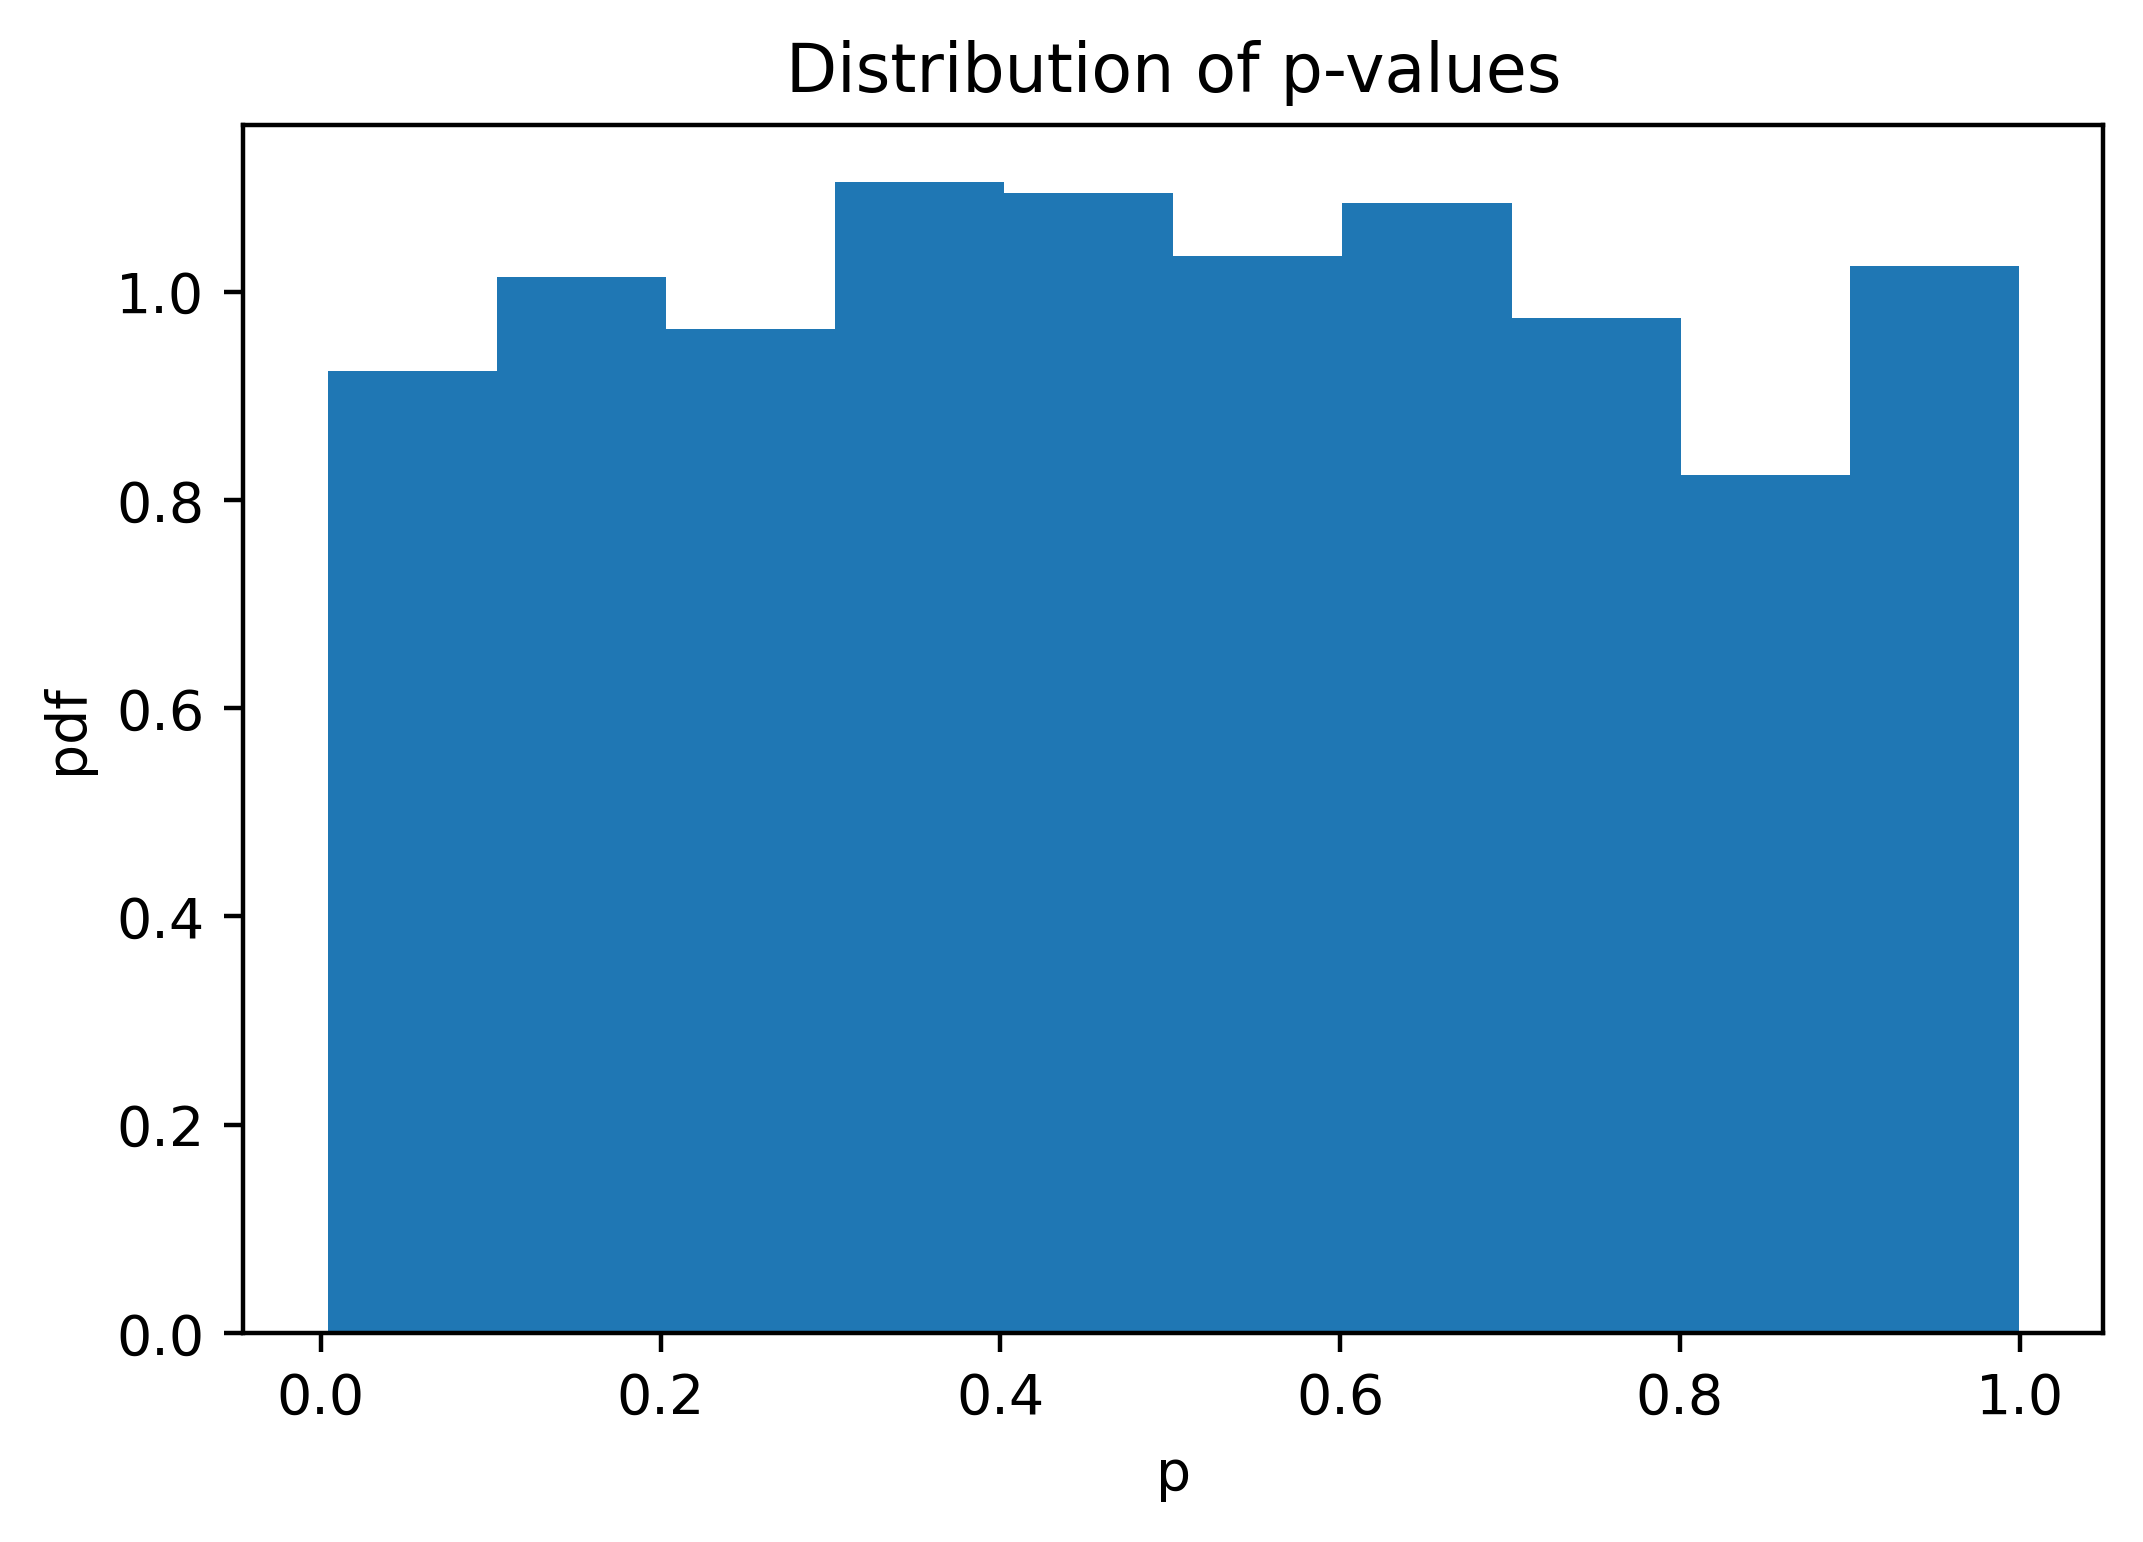

#### Speciation histograms:

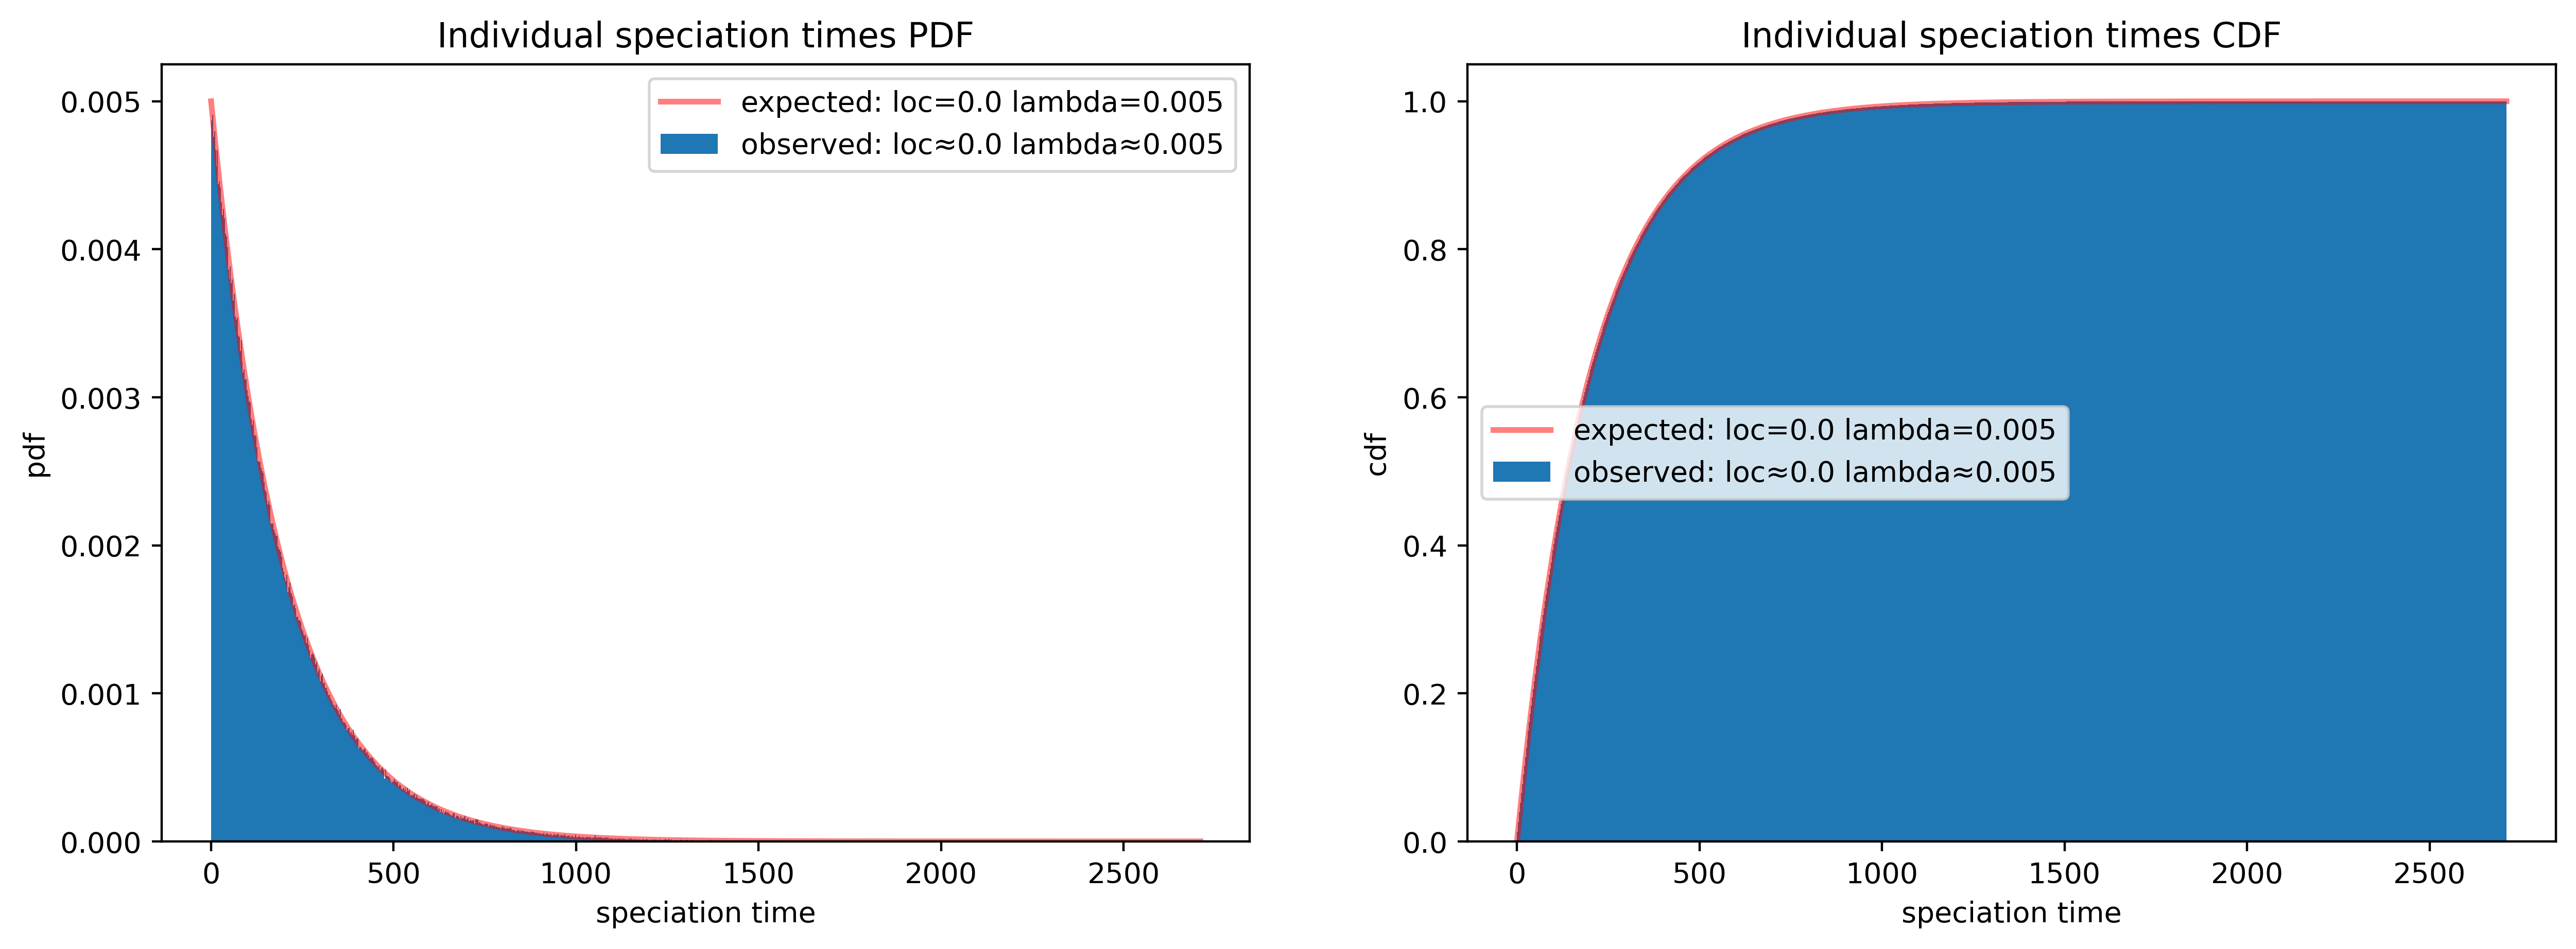

#### Parameters:
* seeds: [17095377146878663968 14074129106928532054 15053169532265281363
 15751883889228729224 10408100620716340074  5987250464804887652
  7504498456940804786  1976540071182586704  3373388506921044668
 16392519505203019431   185326602701629379  9729676775449364396
  9548556802829824809  8928576757953249481 16560114077521059851
  1429708358275485002  8673410138247942302 14028573190249391417
  2922746603360891857 14330239164187130114   173373426213241975
 14518199260008013343  8202757838329348265 16974888481846286948
  7492675828679003902  1902625036266645743  6252720946681685095
 16860030688807954839  1016846271513853201 12412161184376956623
  2782916449941688694 16294334403040285555 14814221810597037510
  3325210202468043357 11968417821785430183  5684999192154887698
  8417517689232415808  4920145306128219777 17920495518987311318
 12081658458430240474 16078886433711723871 14061962436542914895
  7460532540476897362 18141904525832623667  4580309512098505636
 15194354740704811138   265813356467902937 15363239488064357867
 11915337473489516020  3022896489795582399  8205121957848756430
 12432224972257620045 11243375908725416137 15712101591516884024
  4047728001802816214  8901519103442304184 13492057653984419145
  3263286118030732885  4671134539310831611  4733680828258771523
 13574371442278997380 10324658119595604259  1214799612801844256
  6321389070122871931 10943551878880139607 13111830587260422285
  6241286348492336331 16472315306773290595  3852859364421801205
 13170253662872862148 15220387744383927357  1343848072377193337
 12324526646654492019   679777942315035690 15459427129949921097
  1939140359692623466 15360079262116945657 17994927286161047558
  9205083466029576099  4192112444444739197 12763600356694730999
  8767280806423079993  1158925841482593141 13103225406588558899
  2853633685248685636  4393471368351826905  1874867143665833303
   678735512785573665  9483510169133203064  9447584705594162317
   918501058619083543 10666179794506339924 17693004574301920823
   842882093624966953 16043447865244531795  7062875310577682687
  2268348292157684449 16742705782707517340  5391774018416992971
 12736278344752002472  4251438178257808773  1142058046434502689
  5032791056061206885 12547404130822725132  3503254236840087666
 15515353415299335511  6556907262620380132 15891672077442811475
 15294684353860638954 10370485317764462904 17573112623246744888
 14811150691443665498  9385819989625937960 17429080720295329021
  7848397283824391602 16445450031299733970  9653835495835174963
 10653181204065403636  3971821857342362860  7943844153353198980
  2464532381114240878  6627139717432897127  9524177839469580387
  4804999120873089948   101477280112718582  3921951354405783474
  3315883362644563232  7225533305178046510  1409428550195715045
  1997492701621206427 16741394784393130474  6701682744419936576
  8657071714778035171  1530079900408221264 13913121644981677358
   609355353309494452 18216996332288486484 13806038476609244588
  7355481347553132943   655420244300798009  3667387684912628209
   634594466496484866  3921879923723823191  2154593901921757967
 12171556309720300709  1578323192339869854 16738608847836458755
 11993960968474954728  6807150282396131390 15816483557274587961
 10223950835757039677 11108337738981005324 15350081605495953394
  8238915964264953920 17498158140584304418  1412649832503525437
  8427310003833637887  4037950427377275068 13915671333785548958
  4510447932435494117 13917524873179952802 10391157927252180732
 10681873708951337220 10471869838226023854 13094713114403983466
  5697367996572588322  5130369327305727775 15579310083505115562
  9210956463664443320 14622861346030615042 10024959360890033237
  8865460832212323983 13228306334500165301  6319130620224847077
 15656242784868432338  4724878538985693512 15080260927296427195
 18403524332618881096  8083655833781481903  2143115420392889202
 15514837789290089616 12467208200024382745 12120583425093419507
  6091111135016483282  7176433699594720950 13411583485921681338
  5775111455951543804  8726177975989488034  6450021166450603288
  8695064349926490962 11206585180437872552 14878568399152417488
  4477149463290066542  5676680452373856234   884723377447324051
  5045948966673556065 14806498897750813158  7033759763191189107
  9767768355881920951  6403406084047298455  4062752501296260887
  5295659027065473408  5968958432239790129 14881793517310140404
   206287934219939814  3430045639461114432 17175489000636388940
 15836022038394101104  3070912889373749885  8719190139357845049
  9255662695630873946  1312717088121292466   835416758403877320
 10077901492945601621  4660149188100715150  6615505890948952785
  6521395747547573329  7241215581367385409 14463375731745317734
 12517390006654020779 13196293307297642755  2262234829976649215
 14413576646312481737 10001296254302217631 17292689043328053775
 11274941278533156457 12881117010844576905  1334852491130307254
  5510252171324089313  6120454149313193001  3162352092786306218
  7414642740490178764  2370898549974721095  6528364418724821332
  1795229592802943304 15222437830304326161  4474578830186045127
  9109620486924306053   315579263966201393  2599564670034574546
  3123198869717740938  9360352170677642578  9042609401906262661
  8627107150579491052 12520822882487632819  2494760276008585180
  7083154403363104000  7730395099519965623 10436606028075415919
 15846037348542496298 11087117530824503945  3018519260493072744
 16346481529576184910 12434849785368313674 14161210896587737284
  7794598600416542842  8532607942129519403 10903333948809193040
 17094589912051333219 15888202263091588444    55826552783388729
  2229151928242109579 10504356565481017210 10240927955117024301
  5284769443486105361 16486576456926199234 14380831853085891898
 14120685932096456901 11715213391989436764 14680038129438128449
   250162500297567048 14298108374702426602 10302078268775675418
  5223948392203424208  5821066064153867438  4827668868779241105
 15986712524637026294 10702807915075218569 14622432455048199692
  6580201239064667437 15404541230727338363  1953626318483600575
  4710802216203951771 11797541920600428618  7733480232147142581
 12754745779504525141 16423176980206654790  4314578273396733932
 13575048808142972594 10617144341990852128 11523398853613953013
  1128788062722819169 16664333112101085089  3308234492759906910
 15147223614225097265 10052635229331636818 17546539243188641806
 16503806838180104823 15174307977100371401  9499234239265934999
 12826355316392757553 11542349539038644885 15994447951306918571
  7358693258478774160  5020249684050480349 15387289000072356431
 17416540226062655617 13343960140022757000 11847692483418527731
  8116811363442385621 17999598595108519415  2643400371053800862
 12670039257023676817  1547409543667560691  7091408153419053592
  7132259088099528514 17072669668447450561 16631374500002725360
 11422105928547617855 16910881889261879885  2726411158815289364
  6059343847678787137 13702254795075073908  3941797199148290364
  8654356058390163171 16295404880228648911  3783671006829326992
  6972153855340439524 11636023713235995275  1521947738601049687
  6978916874077005600  4162776156569147032 15115450151110484748
 17923859541401574528  9165789289059261808  7080452765086861280
 12207298725600668626  9464633550407512045  7295312247600589387
  8246040054351935073 17098051100891718150 13344778121993594429
 12261590620457514344  7801125321759377757 13772537662243064920
  9071058888080902832  3457572761343132874  8489007049758440667
 17464466798079359891  3708356778580150427  5612310274539972701
 15879243798910630821  4664887388280617122 16451867716367483436
  3635798973198946848 10798231299386336885 12295479054411086408
 16555978982837403648  3687814875900077615  5892990617839845883
 10009048279149864187 14182221323522169716 16676371548681742161
  9655673080628953149  1746434995170914171 13901629873414474891
  2491936886555666605  6477782553121339065 10554763853334838197
  3389705610275081247  3614114482011472318   680028606927766273
  5768635135049576712  4744543891257571034 16404844794464523691
 14357269495941032921  8116207691833479670 15690647772883440184
 12623330440277358880 15221712513452408097  5483501159863468575
  7879642961239930415  8367962879992996900  5062538246471774446
  2030156653333429083 17662910483272623947  5617665337161951676
  4673527678702262515  3668150109240001795  9847913989383770033
 16164340435009563440  9870337461191391007 15841086109438328044
 15876683412132308529 15941890843019645625   471831997677534934
  7338453083515616044 11353750472666194464 10217550606183594236
 11564311646025669963 17116758465678474720   110106311261365644
  5810372210215025393  3092843043142657257  3132084892651431951
 14306484168037753571  4466503025589859396  6650138664917501762
 17672618475266119815 11761307999794742743  8744330233127897727
 17030762531664497599  8158881414464886467  5883163875986645775
  1390803400437276888  1948889258001311030 16635022955211699520
  8784522434198770307 14672392904427493810 11915586193186140873
  7709044119865707737  8209470128355243767  8792357675235835867
  8336747716432265933 14250695383251907390  8704738107453760328
  8290380365515998297   792081973615703104  9737011461617701720
  8315369923895968326  5938248161753231046 15076640331091987427
  1141680904888676531  8114709852098555000 11054586832020369332
  9125440926191109072  5172010990063521398 16662853436789104412
  5068626839616781656 12733765790042852845 11233865626669167740
 10036898158642294963  6898539703849573441 18253110435889541943
 10372906204700075168 16710235370554878192  6340867701807663916
  5309256364391684038  7074175701748681691 12597000046252262118
  6552270280645336446 12342752755358572734 17095914066010461659
 15521281276308411119 12973751564208932333  7508134082780553182
 15467729334832606447  3809615448899668270  9763843487681521035
 13591957629606676059  3786889405598613020 10731689477162281827
  5286564465002888514 15218731400801353513  1832887166266648350
   736080396214986310  1942096804563048511 17499430911360162444
 12587521094016493111  6899538574530058903 12556066717792933942
  3969947623386630814 18128625776712751037 14126394686695753614
 15135171849796157645  8720280568967872361 14234009899310505060
  9761761078136868665  4520056944704860125 15760698546751831604
 12942538439054655517 12646924860526191393 13753414484670929818
  6124705879337451240 13142188918330484837   436986658116337405
 17640040009954061004 10875786057937045388 18323994070463512016
 16294207186979201011 17152462773719743342  9618731285923346558
  6173615689878908386 17594974212633135934  1880679195445226521
 13205918305033986227 16213202273420992478  3856121251662095900
 11664145256246245435  1760848666189863884 13538088680701752772
 13462627589877364211   363676611128090359  3393526165985905365
 14874211362275317564  5648508115754642591  8093705799580246302
 11053909281576508605  6065508646466460824  9998959153765964553
 12165380528506447649 11671583892241533171 16567555311704683840
 12839545532352874564  8598188118892856299  6731969132669010434
 18066742489539897249 16434641370695926604  9033523046979181146
 11032303144608441024 15502427874102554546  8984105194762974386
  2557249980032026226  6781009437069914217  5399323032868519746
  4175013695519512115 12636437670851699679 18213599265587104000
 18408796878457590424  7193216629595959046  1637680922384298786
 14878225768260709106  3979061666418046517 10162549335218782138
  1103737258418861204  2425652451500120256  1402818769960006787
 11395290150105739303   455492563070805266  8760463870447367096
  7157103486942606606  4073174497453042659  1600652601305684650
 11097741641051473429  2683327373075107903 13335651926931117640
 18301228273929005931 14726005908425650336 17841336465937779676
  6008857322616530651  8457473220508185139  7165636189033569046
 12852852020664268625 11449576235001166095 10447404362631783274
  1579393680231344442 18091227348764910113 15125287689487083886
  5829678042407181388  5528541042568135452 11393014313824030788
  6181185021022046413 11672808803325375102 18234037156230878412
  7620272636595221234 17728403660040771252  1584970568552479313
  3345383738121517340 15088411004237251485 14446595904550608449
 12558236105767958897  4150962521916152913 10068941515942745372
  9865550275500696814 11936770060647742208 17472677974302161921
 14718323149497688115  4007467500750871672 14622367673440202340
 15503028100317263220  7113796301705925795 15368319537856132591
  6650178540835460239  6080199282981533312 10527595825296768768
  3018331184001751937 18173715157188753853  9792150168344943390
 12412706048526937433  9537951788825570410  3032655610824007682
  1148286346142953802  4013655615603445761 16677206375223871098
  8370108991744913487 14535403019415402609 13869908910711186493
 14113501834774642241 18066286872427794656 15333607133388782626
 13709028515920511774 16769461081144230245 16919784227541748150
  1823728122333924560  3887058181879028059   740328960512904954
 11776198652664950141 17669381679230268884 15557083646677468989
  1381430215030594216 18254670890233757594 11129425188056577330
 16730600207224463642  7238345622905830477 16501099808985899132
  2037342256754282332  2227109773630861834 18170890789201485950
  6234774996153484994  6481555433928982090  2737553607890684581
 13273203704354174036 17464379612119399007   846344325942326265
  4002624895863781189  9874628735620224643  8094282240914423183
  2762131681363470124  4874829262430990022  5188445833770441162
 18370139640055339096  9090124124021599964 10410614294168873524
  8907812093458777651  4924322152698292024  1409613594040517168
  5301370969830560706  7739019204788708817   299715655592229827
 12846054736408392814  4232772067999732597 16955739306628700836
 18106350261220156340  6275961942969275402  8038398034144499582
  9256192794101773689  2706380696761999480  9707122062125326356
  8780458278531092403 11047006954879265427  5691563450235395174
  3730234126857251648   638348730124621309 14013613968723183156
 17044204973093696616 18248014276460290889 13404159806160017628
 15176231404113734702  5896554647297386163  9249888789678907123
  6268175370048621031  7527943827602337473  3793562132857501735
 14405014518109599210 13799472390109887585  9521041143934663804
 10758118247813667736 16185942760866896023 16420106097234567681
  8727219395598292260 12164313145022565561  7593691290910151549
  8607247533749571751 16646055616920218167 12357522628191371852
  8786537265385363394  3412968527737590386  9570001712688691242
 12070964248862334082  4247336357049562856    17984196735516256
 11444707485337475150  1623759828552743283 11687367644574930163
 10735583253609736560 14921983835602916884 16133395156474762758
 14706382207093583834 14067525660085711072 12820107004948054545
 16628590503324845066 11937922137050664567   333199632613304327
  1525814555806022894 11007346280502185136  2641170174175614955
   733476476292849368  9928660250278555302  9062528679138317107
  4436544879397877530 12208188733075910945  1091875117548444769
  6954185320595731353 18035452371833181783  2943799952152594407
   808009252357932719  2490496695653560422 15931678256206608353
 12471343398040783023  9695904672901850752 11842616457219562296
 17064698733701168547 14300315881141552096   663066447547996786
 16760124160181394207 16137077965928179060  5081872077837078656
  6276633136930345521  3919937780117743375 15695402705584980699
  4629567370101409888 17913183215915051129  4907497814823387512
 15665795122921878216  5274678353015353026 15498083218065617267
 15154582673415542071  7933804177324895383  3884940869927080462
 15079904852032062916  7654308728528648520  2955911422224149644
  1831561472658279196  9996430225658623869 16946900687931203407
  1720732568273832895  6206641285375051914   447453403236526270
 17878930498153766507  1292508054986792191 14708617590119348769
  9722113142658695236  4384484887363539599 13323711411362901751
 16072365930012970119  8559216184425565374 10767949472613288533
  5001027952345785881 15449587750571242913  5466801885574656006
  6885426389261664752  5659736392038160738  2247892108698517889
  9690024846417836774  1339964316239146293 17116478860376883359
  4878758006380013259  9517454286371185784 11731734599247835958
 12165830329437701658 12283031403161845462 14413373361034551301
   405701190800588545  3974155682469237017 14911222811690002860
  8425850014874034114 11176141171982354189  7853841708496254868
 14273798162611962975   398567761816772574 11962356720543646820
  1993312530073254818  5791829322761961588 13154219849534932864
   593089732625186100 15012086691466000061  9437146052711300695
  3875924668754772427 10349541462003141188 13216726855025002260
 17729677356141197081   685963016374418649 17301374434089573816
 10765940953774699580  7554599152713238420 12747644650514301347
 12953484527061372790  2291426941462214361  6752550259943585163
   206250185281396291  8855871002077593846 14216575031520606362
   870864095341185826 13261053089628942115    55345679153209287
  4227372439775071108  6092642101023724541  4022203994527224563
  2450775459370249290 10649452232550926717  2714215562637893697
  6221057517940992841  2590688474876458374   720970462053155294
 12643252054877585605  1342588115586753421  4050149339302534764
 12265373554313650194  4629332947562884004 14272274090559114772
 15111386685841099607 10736178271055797952  1228081614235610214
 17711793654002359950 17104502448368536563   166247044157360411
 12258929437813744560 11202169908390400327 10252944015556234297
  4201394301959847546 15547388680986414217  9261982472213391546
 15689175214672989686 17676385661067493058 14537641629491233612
 14304214575772674372 13796378917724586881 16219340667433510199
  2511532069672147405  9871565991451531470  1475491834504604336
 17619337534254429998   825934023895156400  7110400400024052926
 11850780760431701985 10003117189901557738   981125471612862211
  5428862083973758367  5819627125050436284   141108942490720437
 15905200730475856646 14329373954607369543  4795745233791435996
  8622186544555967873  4815132980602173390  9728235469600365668
   525351245378854601 11973728386781321759 16530763793724736495
  8664555459034215622 15877155302511917326 14911940873807955470
 11098757410052606980 18382474214697784055  2310071741869975551
  3084757782470985415   668154599997340775 10196286077664717082
  3953774506928662022 17038111513998553721  2772762671818314791
  6952420857992405292  4038494160642933309  8746055841105210664
 12279362088356592946  2611923608294301804 12259613595848489776
   982467902186883652  5619228327724670527  1389522779636168882
 12150202786498806151  3611526486084499176 10896611872712080814
 17349157283261477299 10250148587770744841  5575654889294237668
 12407796746441915811 13008134220650876636 16853069226583675269
 16835681077886935726 15391416870144706000  9835071506397301512
 13150551842562547769  2300708963473105244  9690892225023680899
  8409550333088668673  4952704419865706820  7633113334153966947
 16526672822227790829 13795757921937351580  9349491866030111576
  8397456328293698025  8469051487740399414  2906460227965432812
  7431467664044090451  2002648382063169797  8396688090970451513
  7397256598255991899 13524248618594377282 14973803028183707625
  7790186825181593062 11492198521119257910 11041152690555904007
  5662777529714325479 17376952003081112150  1762414670377799513
 14666010334743331730  6697654437994543558  4189406860893374365
 10034235895405853080 11095345413502141295  1076380145666387970
 13062951829918717979 18196865497820975002   788598894060602312
  3175314496806868430  1558107363939794329   734872486024667576
  4751281615659801421  1162532889872624603  7710942182251707253
 14888915107326968789  9004062118661923759  1189798382959538166
  7581588460370329122  5299610275457372320  6033860467235030020
  1617412905126659800  5987446241146299699 17714031398691725679
 11819839063794598813  7303192442112423741 16446651456191762568
  2122633632162082842  2851989239278196461 13986519820172877602
  9551684044926282124  3259097716436023823  1128836659601784877
  4123977006224800108 14424661265809838639 10731994023599297265
  9409995502164796027  7866862663452462571  4515660828811112465
  2645779287395240549 16706199013987635334  8377338634043357067
  5068632997822313022 16023402702411999093 10331141541794678385
  1413555382503615579  8202022827965054633 14542090834740404254
  3836591734177848906  7985012055482461315  6213456463016996846
 14275421494640842514  9614341380974409823 11766143095328495679
 17146109731219329357 10978428838996441191  6767416713193166163
 14065889497509013809 14062876539214856340 17133623722943936065
  3271369508093508253 10760561515170600502  4826711787481392563
  2282902300127137961 11668699841644052306  4303866795917875616
 11215908871155581486 15803843536552081193 12947387758464991007
 10477309422980323677  6194843210855909953  1781912254294110521
  2646986537403945775 16662448173860343299 17028894245619190218
 14385912324828383607 14011600549080015350 10453104829961725303
  3852741994096353655  8232026238359612424  5763036913890700566
  5902182037537421147 13612734796596590295  9444466549671703519
  6556094352427209778  3054197965480321371 17906425671968829958
 17496554921731311470  1424143054160739809  4056849584024878834
 12147833509150007237 10965962923585668198  9727568911431235640
 17370420452856475782]

#### Configuration:
```rust
(speciation:0.01,seed:17370420452856475782,sample:0.001,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:33<00:00,  3.66it/s]


## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.7528370251795522
* statistic: 1956.4277737499374

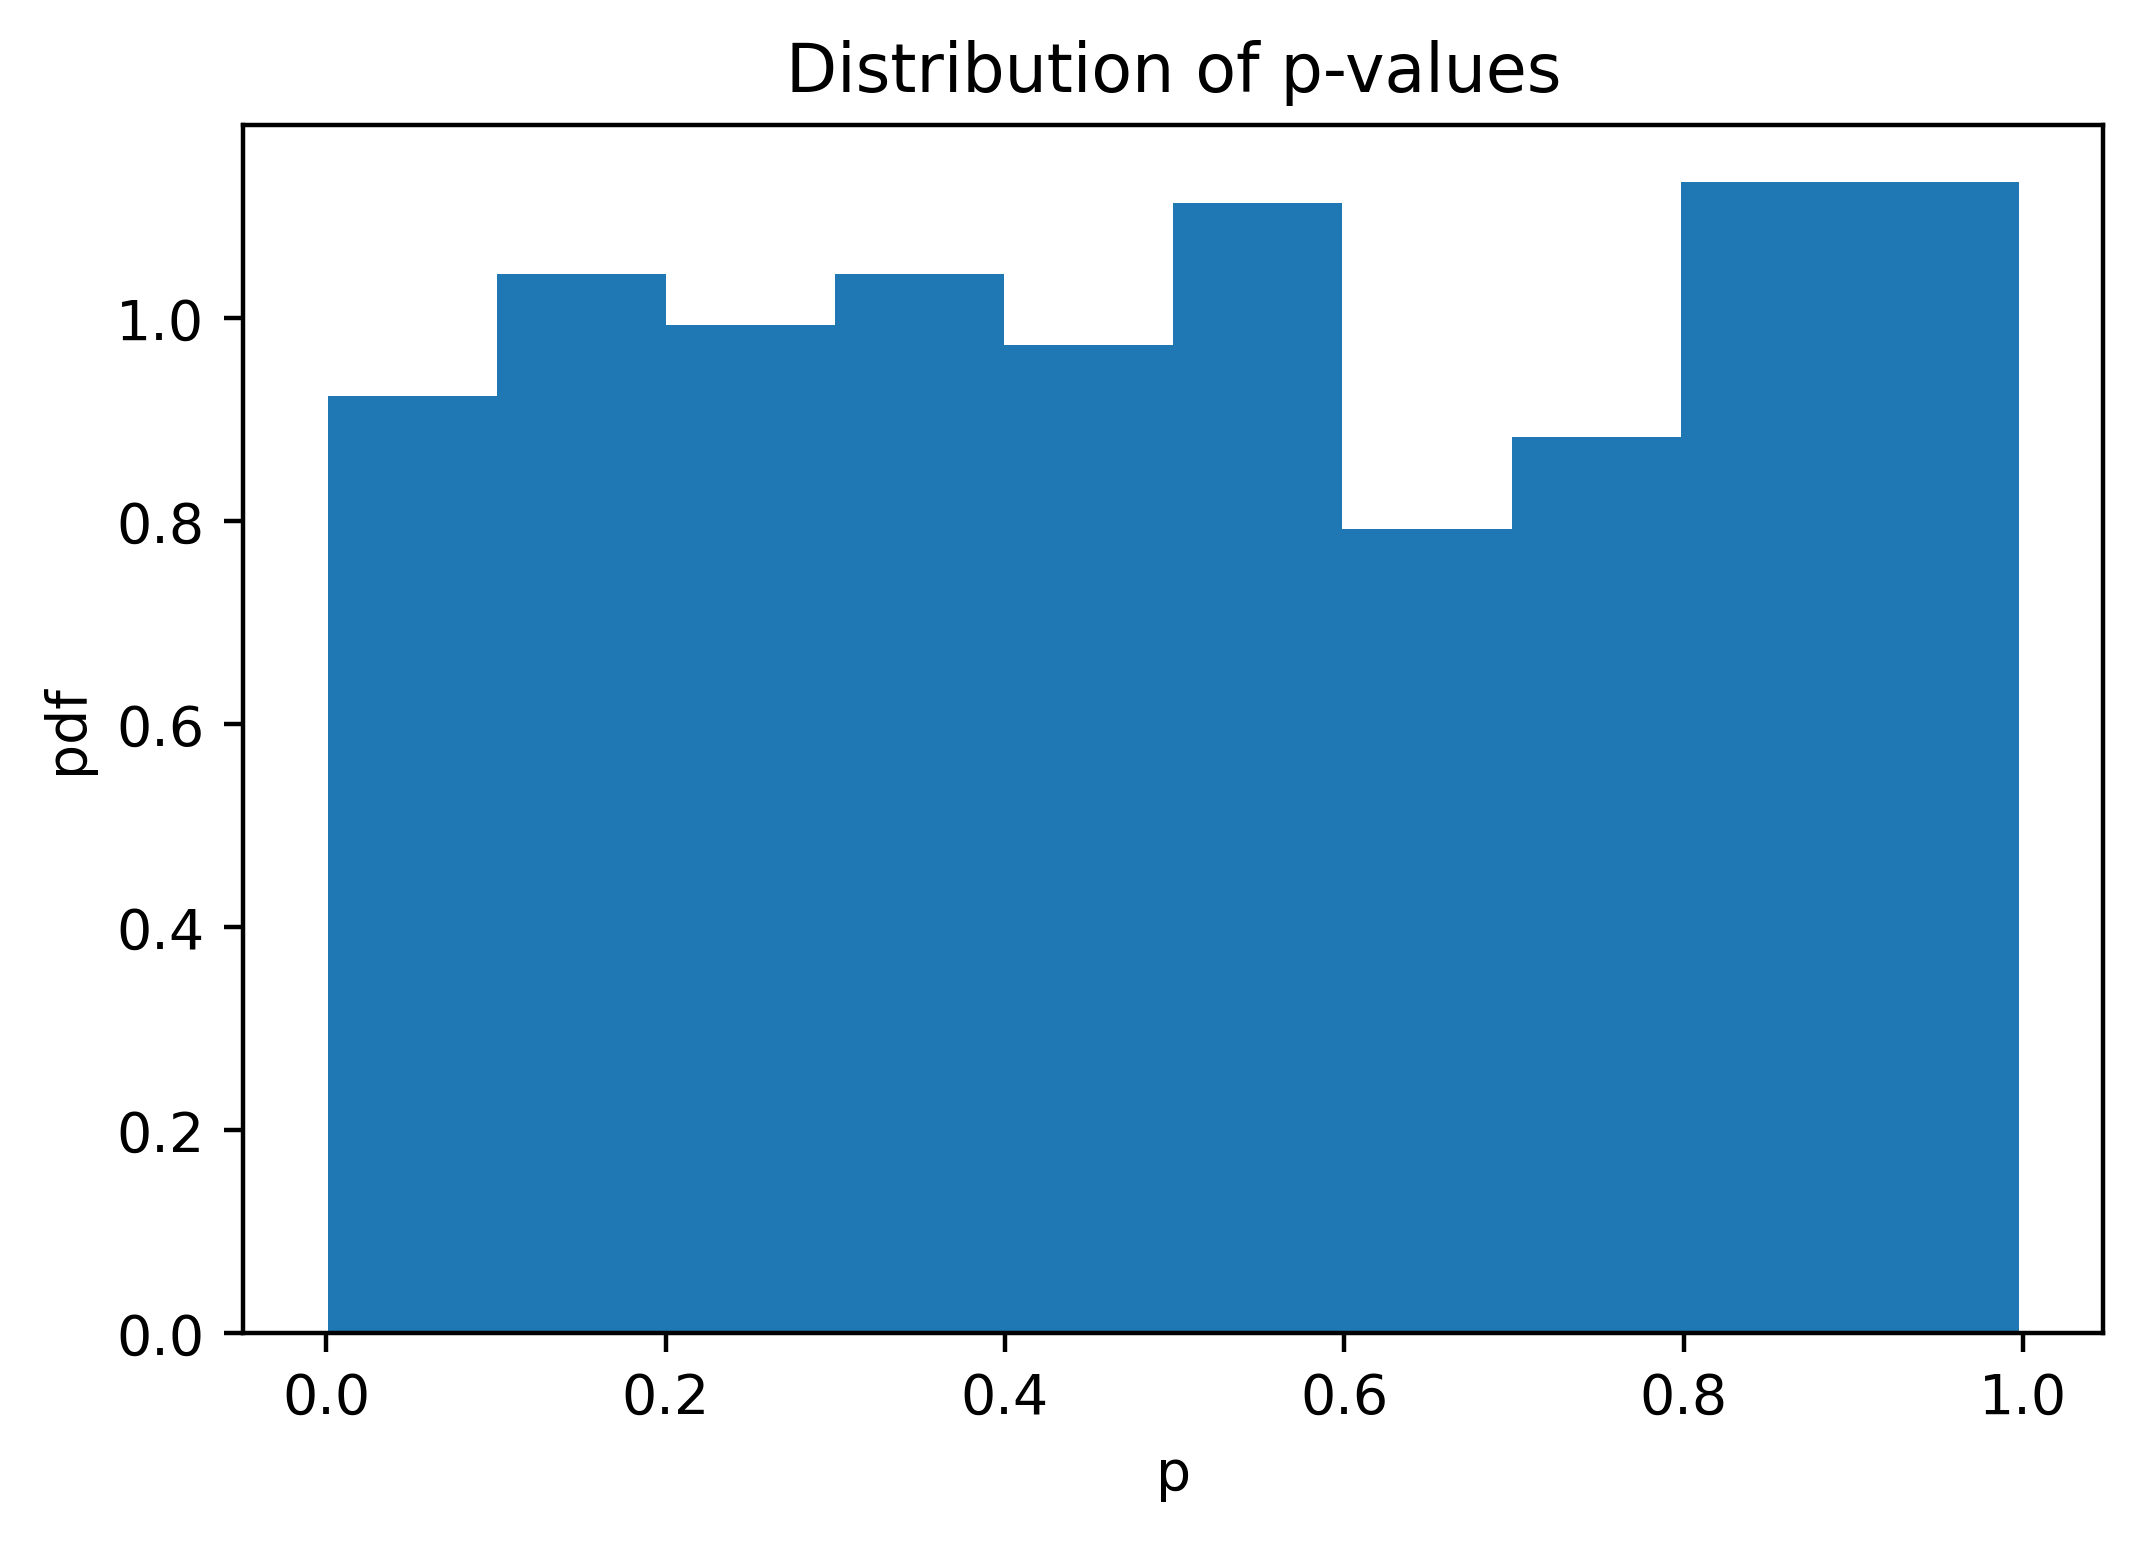

#### Speciation histograms:

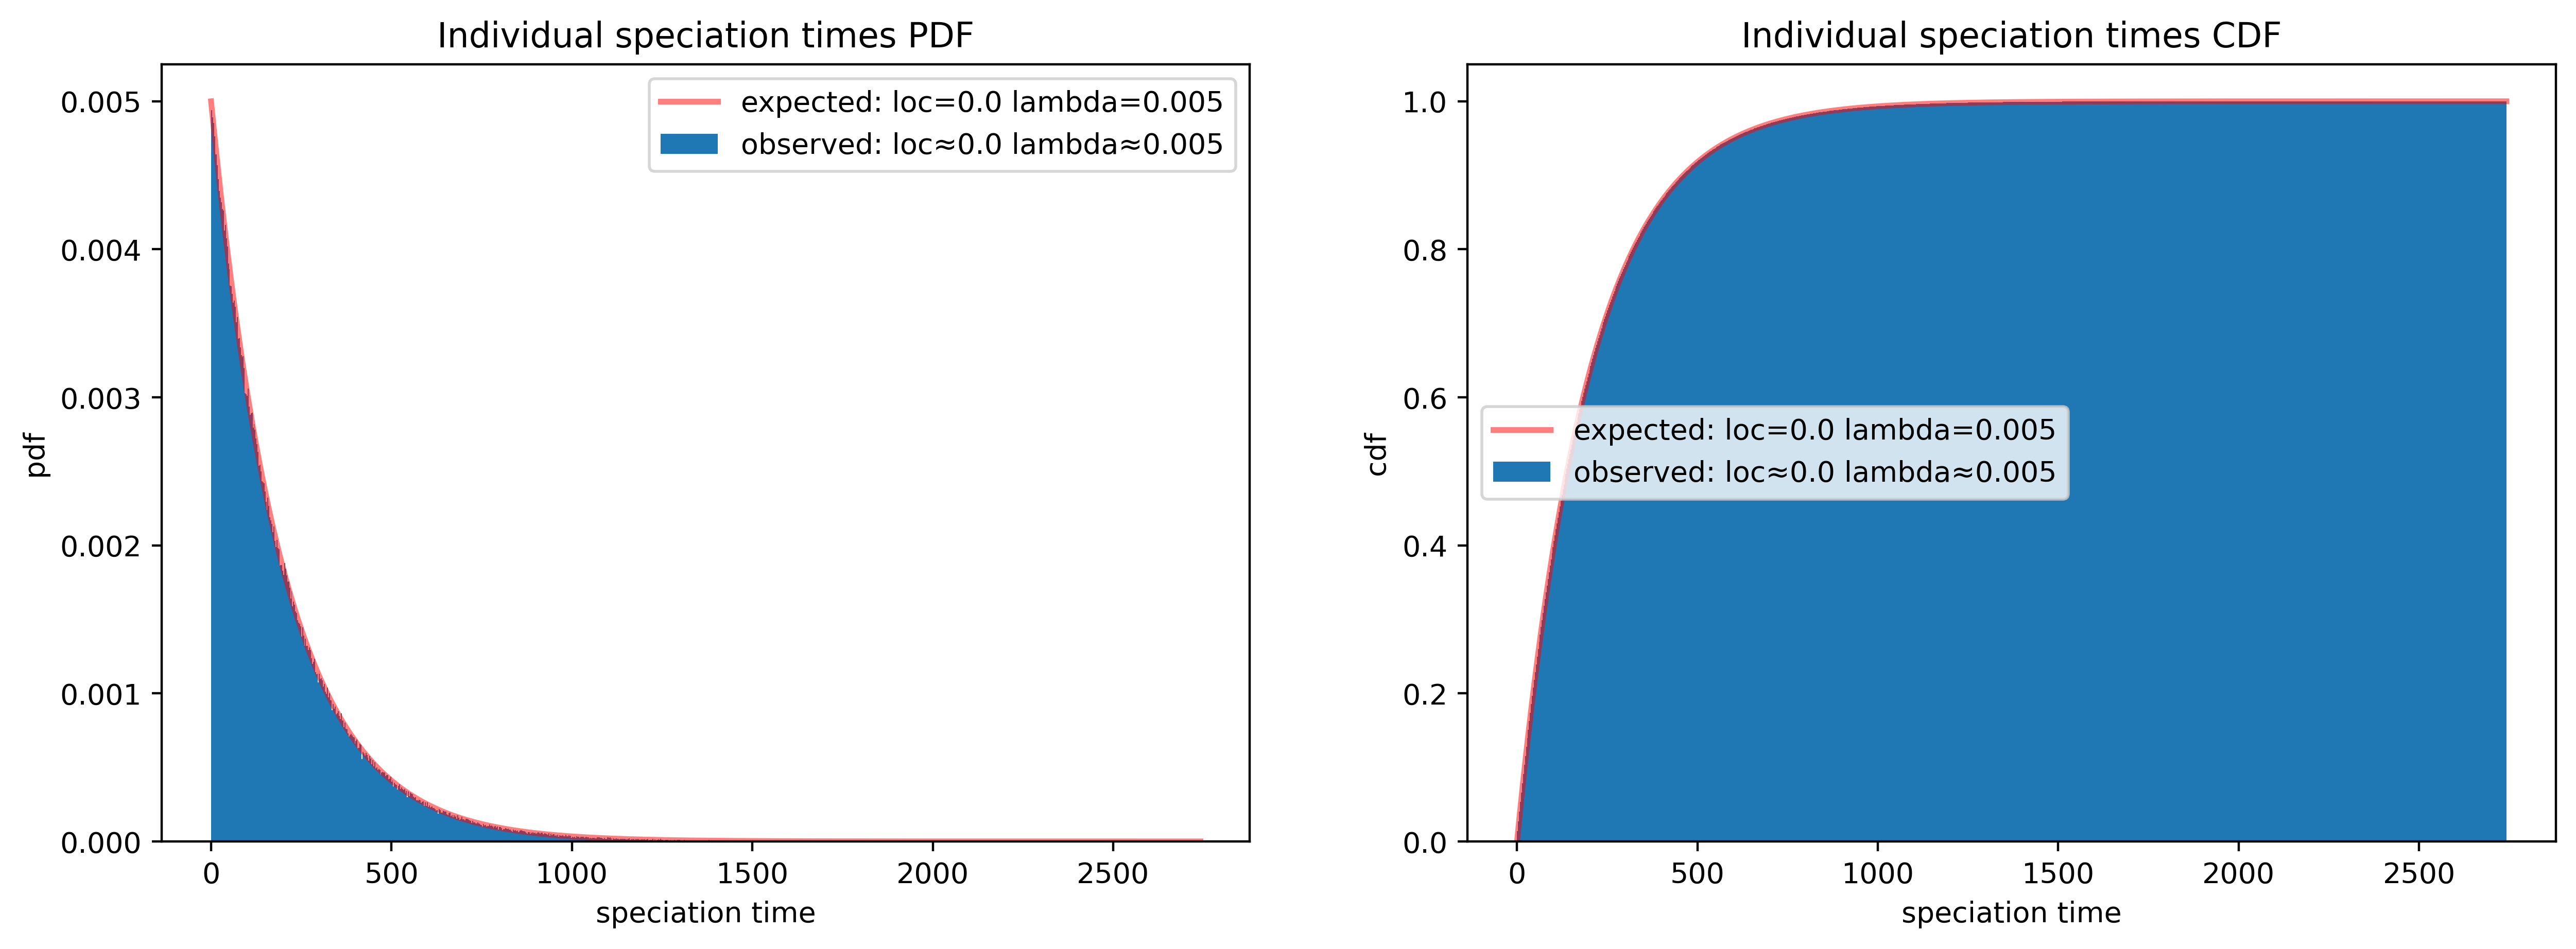

#### Parameters:
* seeds: [15487858410355824677  9655624398640398464  4424721782361103431
   642467110579602915  5605522791034663065   752994280926184800
 18057402581310953238  4339538060372134782  2703598515320162012
 13011574901207772372 11357279835506000114 13037954069484001616
 16887313197664337505  8739280653972904127  9309773709106815529
  8182208193932242967  4584715229551941194  2264734469430377581
  8844818701379873244 13502599735057462908  3161639180023676915
  3402391966726698874  5328422522167767586  9962303717191382722
 14772937619605718659 11936563688367915850  2108857233493320315
 16218094007861682154 14312198442998756583  3042380324310470743
 11733948717843295414 15212281428691921194  3369932046141708505
  3225168391130283308 15389040514668407046  3150052600669169851
  6453504925192965071 12261461660374780147 15391089095638069192
 11614984757750294200  6097653151887715441  3703755662859427152
  7891576539203337411 17629598499104591781  6042026805777007571
 16478227047183709097 18409068176989967978 14072500786615912053
  3985834167397428998 11325609472758310149  2206504860846703232
  7057634584446212774   937501861240628477  3811176165513308339
  3557630465377354646 10762684222938715753 16155755493088328438
  1018768770153054118 11252421125197753641 17884295908848640877
  5922282570706856330 14719099629201397719  7168766307699434175
   407507628711706202   828436751930125891  6315958940258916764
 10023876941058957115 13633647973163069803 11980655188437089030
  6264072149103556985  8764003704410630616 16822653496805641921
 15191493459996827063  8389214660015508753  5986219448749560186
 11260256721914449034 17913686777941017378  4924347093270794891
   607750038447725908  6829999975754450416  3985837750908469351
  1016128550710410491  7995256225278078064  8262342769304326314
 13312816122837651623 11512744737121105948  2426335120425500302
 10125720691536835647  2843872157253264661   833002780887560874
 12393656674672056186 16112298602259998453 17299461140037370321
  1132669165165645471  7333802953628759319   659198352518360146
 15671815837576715592 10613611124464800632  5383076013517710260
 10779583820458830179 14997890679202528795 14757327439467296007
   186322549976785649   301852905757252928  2883208363182160631
  2980957764580136629  3026528061420324142 14286909008263643212
 11382002964923493739  1257436269174663049 17775718802691472780
  4592443308628338116  6981216371112393839 17523466329411065306
 15194262461854980566 13996435597263084677 14221416313318063995
 13901832013926758276 12574480604044613818 18043056813313694085
 12188012294939955312  1539941361294056502 17742433375548861850
   500308889766138523 12726268590256763075   676157460677449730
 16567814013390059897  1977555529370848002   693454415886035566
 16730564151339951125  2544507793441638437  5557016795896304544
 13043668774019993736 10294591040980565539  7070070258426831922
  7425365237958594318  4346574666599142210  3818714683814268486
 15277919477254356903  8608106596590736809  2941220992408661095
 12343352178171669778  1369539718319502088 16799842634254877539
   392493056982332031 13818485522734914335 12875712476160512286
  1136740221810544321 14288344742426626861 13474801887312022528
   640762174875875978  1484408708654008789  8959417015879972433
  4134375219110087740 10744198958922742234  4855859520365425389
  1948334633884939387  4268818421028502173 15546483654899618744
  1338684885321498993   433364899086877971 15119891333603174715
  4187401173156654722 11325252569822591269  5658149349823327795
 12313186410375880222  7458610485443642551  1724529415881387557
 13540859911517308840  3224074411015007189 18122766496737339720
  6607283219746812809 16392046333995938575 16512505988626881393
  3481932931958779429 10747457685753167413 10249209207505032318
  5610816288286765849  9218206293766315397  7323212777686672477
 15755853735502300505  3288506675573642467 13234056408902992581
  1232696925567906114 11506566215268926722  5778576669135654149
  6313013744243660871  4760631435446186938  4081369358721769655
 14382229006707757816  8013558932884560366 16752234668138628101
 13713235777266399553 15521981516491604970  7814198497913446748
   930555461311165207 11979233755153907236 14811491864136319024
 14263985783825469963  6203257203486788548 12047503126134157602
  5312051996092995652  1192811901481508801  7617222251501448597
  4260265031986223087 14995113290438038720  2628656518443803545
 14253655137423870881  7722383568998157887  1418298168855468580
 12127852194369154504 12890622864898300115 17706825097034480679
 12665252233685213236  8734771313479306342 17565059151567856198
  9532263737860094500 18018478773640560994 16881747932898126355
  6503742257136482062  6605584125387146670  7911232484591400751
  3147652555257819783  6847997846440615437 17368312470343893872
  5255826019167026436 15022509555424453612  3737395896928997078
 14757845089293118654 17331509397700091145 15460491388513441381
 17998993596992476259 14325373633671796884  6105697556692222343
  1807371271841051952  2728087978895824716  8119972217524834520
 12405610526385341849   865881549930004685 18329448608268319935
  8188973620811396954  5368950743332145027 15616504399531196326
  9290774150586262316 10979337436662092393 18242132197517259764
  9946407194868390024 17166349261231964778  8432438117971405943
  9681147737261192467  8461163297376770158  2374055771430951845
  8143017978756018323  7020720244380757804  3507150159408541706
  3351418816217156549   243082454431207485 17226104422868993979
  6774606827811488075 11708675079327623408 17256831907909081995
   657670722301343460  1147267382714590272   308372627034195549
 12546488147321439203 16414583052417375374  7345477082407815720
 11002931989940307033  3677823669687758865 18246897007853958967
   801618786509387518  3222400575506511035  7038603118871736157
 16421315575455943067  6801115738091551408  1644019958386562829
  2885757343428066168 16463661108552518243 13310044360062516997
  1166289709619053603  8013301344955009746 13467929292374001088
 17051940487743992010 10607038557915968709 11212041558283990715
  9767513356456364213  4820265323262849066 17702992903113657011
 12413555942449693100 10815288749485448802 18007698589854747770
 11514708440885023291 15464557347646200103  4655407609491851579
 13165395504136766842 10106461552912269707  3306024120934177996
 17399368213095350690 15583793140193976219   515798004937400168
 13776593505448447255 15707603533304262561 14722861743949061379
  1743710353989132031  2782349709315617931  1776632772351480112
  4630099760538005478  1786403882979388515  9398182478118790791
  8307885030998005779  1106569997093010354  4023776789072063501
  4939214221301954232  6560031867217279622  3285141147738938071
   384025869846703442  1229501209302429019 10059198988797381342
 13246411530594175645  2475450972719092980  2124066985456982801
 11663474130465598524 15045317345184754364   981959603351091289
  4631650590598423117 14586375697321274045 16485411032136494775
  2219233234192263850  1484657979427314053 14516325395597530851
 16374648564709273590   571108407772912267  5220829834021303165
  9950927736308716552 15515879150116333984 15268848597746461654
  1128070387071471617 10337629134622611270  9695479340407166834
 18019020986601785066 17209188137821191996 14042438955464074929
 12107723333758340867 12548475019549243230 14104563564518855094
 14439450463906756930  1794746060993229309 15691321829298100872
   679187652244835439 18126140116207404538 13795976171391725704
 11482499757578931499  4081404092831982025 17244035412172965180
 13648575530376145217  8549275184854229995  7749573777966762738
 15319240286541471412  7092512125309009929  2915741600747950809
 11158236758618649212 13383421106441742366  4922027960243182638
  3831310320437360835  8810300727338527575  4161544824173726719
 10204553932700032375 10267309526329561956  9968769401178181610
  2568484016364526326  5006072626224587948  1084336864087107444
  9266407265210350784  3865064900474814676  5710919887262724918
  7180729872305378966 14111506511072259260  2807786667248641789
  7796248641076645310 16956809418513588629 13414679180422933933
 17513805684063487775   458055482721568153 12660043449565755566
 10282686186536169053  5091421092719650446  4266665552302889995
 17591271095002908076  2898406548880371814  9888181503982993379
  2462230314501569258 12521432592475488597  1530868571346522105
  8660389621186337354 17447261422464045594  8302200974376471564
  9018285520260031745  4171874037342679071  9132862887866523863
  8130711460885967260 15228630528738628885 16163771536200555330
  4164930658161986444 17473139513019919421 15902259675522460979
  1289371391965605179 16297806392578154972  9665099510545045239
  9722504136914090510  8282656446146970313 13101507875447051132
  5595951092465164006  7428291767686592866  4694818553505848477
 17779527040427311112  2509593164330151328 13733451190813285562
  3059144652078949316  1741132233063400222  7818899417137863526
  2048777198852201902 17544069889677828241 13306129960640004011
  3992329498932735845   884381904495123355  9112842779326123236
  8193234589967139430 18183761181115805736 15460275321261141592
   605773816392569580 17509989355372519354  6799519498796328768
  2492285390411699503 14311861443726739220 14988827374966604098
  3699466804760367081 10535708634269471539  5972809075985838166
  7781354031020103836  9487137907889432136 10437466382017523165
 14206504974816203549 18360955778694287098 12943539662148165184
  7883920161110841168  5597338993452617535  7931963047363587625
  6078441681552482200   758065740172426677  2287641422817868899
  7753655563440901076  8085219875470771076  3705863340502290101
  7982561143842474712 17314742463835745077 14245288455917200201
  8929192886239054866 13521334339159482556  3225263419964881231
 12402435848363850115 10025754793928806949  3151826711796747453
  7149562556394825892 17790040492302561387  4128291349029962464
  4426987859058497004 10953471172979158423   396866303047725390
   757074874607706619  3259770471250943454 14023768400810931153
 16672167905130137054 16208423661629026555  6494393394860259663
 15795084813041153745  4240039239076934276  6788913678039016012
  8719698454752867564 17510252662840804134  9133061376341218080
 18292677818432310724 16392392189024384887  4983614660499178897
 18398713974858558663 15296649005680358477 15332991421616636360
  7016946431708903828 10608668290364082892  9114442415787221434
  9343668688596829874 12937119749131610415 13680168086883441319
   843596712337331627 17747504108122830942  8213444561935051866
  7690785741446665287 13976918506183418460 11204170840271568201
 13947088083767814383 17770299376408805773 18358216665662969972
 12829588728291656766  6054222275901505785  1967877774842673139
 16291741304133099494  7882258415475164101  5735009598816582525
  5045162375566022076   102436446465113126  1137501593443464975
 17292768644463217830  2157006653395458555  5264429034419100820
  3078513511315154373 14020906500528788141 16074857801068590870
 16404633983477330117 17766352322120220548 11295476943106184525
  4612970984837537565 17863386330513530841 12643654517479602834
 10981793500949506476  4784441613125048520   187496278745011577
 11859821012044322585 11114065481995800781 15845150697748697370
 15911440065881383903 10067809259415151463  2370089828223547905
 18084957135729201927 10333368930456437879 15295247822281534053
  7106567427111034463  3627520631737591658   310971942929890152
   164163431534670196  2750277826050530668  5931139138798429741
 17408777595735168612  2015021932722078180  5131317332674004461
  9694447915578495037 13909493876677109644  4965558499098618716
 11260813662673505307 14774635299288801552  2790511385064369404
  1076750589582428941   410214583851047932  4338454359017355417
  3532861289942866379  2834803142588751804  1116420173117085845
 16249868779962585213 17621187205555587779  3139366702112180433
  2337337817827566776 10862882379155963584  2083500926394216878
  5651815516818308900  3778773072041994717  7304580131929916856
 12614957023244737593  9878666108483341719 15945010289602422785
 15800848552460522722  4361824934300508773  2838744833258172091
  7242573860349993410  3264129372860128502  6506293695257114389
 15564860996587263446  4324314076167634104 17323032844536568249
 14808686449254807244  9016212138891346763 13286910503158031265
  2692071327411784085 11669139012278719033  1303955944891393753
  7382834290044536994 16422233749759359223  1188154168578077916
 17289578927236621786  3157939978529657944 13706509988043742490
  4780343741263023946   513290748111314845  2977468721437198182
 16255076815198270731  8034940243356433998  2682808805049767733
  4550782519866756778 13990295424558680399    29833653651968975
 13569774297650075574   449770086340810215     6667281600542078
 12454322062549140765  8394964863692424854  1170551771930893912
 11997802243119266995  8009191192022208677  2188197963823139014
  6000661777354357102  9459862945015428882 18422047747493869202
 15291386254373292672  6455214734481964882  6213229936828850813
 12209658348035799499  6850075590256280747  7114478962229039294
 10925545997615352876  2539341865467790322 14659433962479475075
  1255622155192292340 15866453880930943532  2298053683918298633
 14662951277119252794 17958362918789421198   714255746577228965
  5487869234638615299 17813264920226625816  6775002890094981591
  7576438815866780686  4550090907074557467 15027959429209372588
   253292298686380424  2818763056090597181 14176196516072821838
 11891525546464425650 18026732148531914362  8607791327692926578
  3320392898316924830  4727972728666930093 10387666488032244444
   362904608654943416   184345499761904024 10038608898046697330
 14686955862285361571 11867505682227058903  6603801957422539532
 17177886799361932148 10427487815528457055 16553058730146277081
 17342479265670062394  1855529134540500729 14254525563878564093
 16519167149197135998   196718829426534869  1462399533804548033
  6462797434425278846 16755818483318599612  7608600180154328118
  2481943042352895275  3520122277773463367 14837488144273612350
  4910759443041182513  2240448536404537662 15600110988564691190
 10055017664216703565 11502903711094179930  1563468357041102243
  8183554524598058219 16729674975174567544  8782332042765159983
  5877127213889210104  6973114851072624964 12882690937682304363
 12520685633392541848  4373690593279788768   972637669116085745
 13783753563145787476  2886480732491524477 10216319282545317814
  4200255881932465838 15703659446950303688   565298297670680848
 18229373589625722252  6047555771866843229 10601372416204164430
 17318245770759265406  9967280521644444981 13686500913412941385
  9044783996408695665  8612124975227165687 10145064019990051486
  8765784690138971314  7671957299116344331 17770910577730174821
 12211480036833330918 14936291718005847314 11959966547905481593
 12857834464247475773 12706479737336605609 16283678408102425042
  5104271720866533488  9660843952906525395  4903680170370289698
 13902505850356924633  5797304460046624358  4800288711695380562
  5850217594146862126 15584472078989559520  9463073609050265780
  2391980150432700114 13047457599284999978 12088408178943376404
  2553936738128851826 12166179175908241956  7829550656151488176
 14573811483812953306 11660207736806322209  9279520007154653659
 11477659125349807407 11419746022081416596  2759102177230432678
  1737664848372900432 11754210544449664505 13375687740648497513
 12741144694727147283  4711174558059886674  2259558073450205277
 18261333555418097946  9488093717760898981 15890265397429659617
  5151052152716883195  9154352660802756401 13083672752743635659
  4282623180144361359 13268432701996415608  4931715142334018241
  7713730129390831762  7509427055183707531  1435963814291066106
  6720117759213382347  2367485410114004845 17619114411090313083
  6509143350782206166  7472492001020748698 14873489874353118676
 10439528104942573613  2345958673751790236 14042838743702910083
  2440434419322152166 11983885311627223139 12427084332087577501
  5983290154558569417  1383924958568969231  4556480413307669497
  2456643791241281172 17150277489171417329  9465609137703409268
  2257653442398216130  1386461139708213613 11876527215783691857
 15226351535156472562  7962714978920241736 10306473566477716604
  1306048126056715343   498863683844392027 14390000538186016953
 10004999131797783464  5862330192266493176  3862121113754813601
 13513650449466945373  2508432755090460552  8934881218198790465
 16287261760482853858 14618855007825085081  8865852032805494940
 13306157074095348427 14288602319807741381 12484967023233004957
 10218103779345255192 11130565988689679973 15330730104450562695
  1441889173405290123  1417041184110705435  8699535932121880927
  6242428895589625927 16546448608862597632  6568112384024296887
 14651264631299705471  9163315368700405388  3283570834037105935
  6264222507429546513  3790396417483883089  6855117991514866622
  9866196740658515692 13891653175306274190  3618055883220298857
 13170331914791596096 16298620012743093441  2201870081661853240
  7730888425372292539  4798958196526721170   658563512620042542
 10496559044156723335 14366079706533318204  3226658917230913674
 13660401222848559148 12113265858577886754  6339651088024818039
  8474873136247880386  7473497303832006784 10753809910738054666
  3694791549864834899 13634497707842590602  5866274778186783293
 12815581013009808136 15182050367724904489 16733370446315105346
 18333213734124071195 11351278728202825825 10298148196217106285
 13007970630585446783 15156035650201175588 18395627236162405363
 10475665492418566179  1626077186622933184  3275579335124535324
  4405452969490450674 15449663700398910326 11070355982062879831
 11794229230568666055 11309070777561068622  8988055899776833924
 12291563494639181430 11175475020425817393  1527084736678764952
  6579547371173527803 13668933840750832939 11673398702473912332
  9267349643186318683  3531846738727087555 18022696191043864607
  9636968752180503212 13688989773533237071  6864064241016483451
  8903235995032712556  9778740857785346749 11316804557409451219
  9550962447887879308  6280945536185750916  6962601534804740463
 13492113222976972769 13935138020584125810 12596073313767829528
 17828554886033702880 16291755655055103372   414395273579261367
 15111536944897409323  1032039425468590393  8407286562836782820
 12052169936332181204 11419388563733494142 14175587790668499452
  9124979651649609775 18138450170435712853 13659160581027613129
 12977828700608894614  4591614849320333630 11510546767052205394
  2639994938569863483  3652599727380277260 11785608502328672864
  6447314304011744727  5350252720944694757  3881387815250296849
  9083997209968183170  2561203176564975615  4550268912547651587
  5017887478034748943  2942957833258387678  7763234034208009901
 12578477238753517154 11672776207301634484  8725923293600289822
 17312078873017809409 13877469890847509132  7729758454702690432
 13849753723524111449 10508919111704050340 13095605617770122779
  1593199619851512090  3370385084005933830   420787279982408444
  8484844724914361618  5081046987039414175 15174543064709642746
 13732449536056021577 17622429317150342720 13524299696622116773
 14930787051209551756 13052325951248101261  3606125362276962492
  6648177793876536021  1610365007108461080 11136970674870796695
   924617725424311068  7074362709230905876 17780940700440376183
 16792835461192697023 16070923033288742099  6198457981150271587
  8210056196889533289  4259895098412765876   550073622994928852
 16601752715410625928 16445637231319047989  6978681020657366062
 14261424222862521751  4423434323962233842  2382019299048496884
  2705689150749894753 11238231452714233745  9207998328938979846
 10744371036339259798  2628950874857807374 10265877109710301679
  1410180359808182174 13850719904200204596  8768057500133540286
 13026877052228535120  1800932687933132808 15244344941468487838
  3290826145892905029 16745545981903597624 12239208700448539817
 14630144192329882559  5446299597678108859  8439579313651554003
 18045235890430088658  1546586874262585448  1313550118366743310
 17948310976645919031 12751103776467232262   387661993012864945
  2132283946058532591 18156090598820026896 11856481658299219153
 12080619860980605434 15715270681984276007 17522942323628244127
  6622660876643553064 11958556659530041138 13720120789774726911
 11427530254651393525  7565696001121058625  8004695835779738489
 10872606487154721298 10018337213144870397 11135679768350901782
 16434873297536104779 10948659843515851833 13422124697486486946
  5758733026941716395  4890746612936215099  4713507650408676879
  9154705111762343914 11874952929303210932   592433662519556814
 16903439971072756420 13587544604737811016  8977879238263687910
 13295441536880575693  1064566291318542174  9905828567996524576
 14745588067736392947  6066567842511091803  6469602508648827814
 14448544667212316048 14655574089476086662   821484573479473813
  2463376214860149658  8983293954461793355  8746110254117753909
  2747223400360027299 15340434188737043439 18415846736218648860
 13273965977344176427  2764206764511535885   394773349958065368
  5589869717537457031 16142098553851851589  6850247056081946581
  7342458848911146838 14926771957664006263  1374379079551884760
  3235889832769102913  7465166822708976463  2765062418533078191
 12368997080202931653 17756894965233153362  2190023428860682907
  8635342276633723042]

#### Configuration:
```rust
(speciation:0.01,seed:8635342276633723042,sample:0.001,algorithm:Independent(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

In [5]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_speciation_time(algorithm, speciation=0.01, seeds=seeds, radius=500, sample=0.001)